In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.signal as signal
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from astropy.stats import gaussian_sigma_to_fwhm,gaussian_fwhm_to_sigma

import datetime
import pickle
import importlib
import json
import time
import glob

from do_wavelet import do_wavelet

with open('data/selected_band.pkl','rb') as f:
    selected_band = pickle.load(f)

wavelength_full = np.load('data/wavelength_full.npz')['wavelength_full']

In [2]:
selected_band

,Line Name,Wavelength Range,Initial Guess,Wavelength Index
0,Ni XI 148,"[14.75, 14.93]","[0.00011, 14.84, 0.0424]","[588, 589, 590, 591, 592, 593, 594, 595, 596]"
1,O VI 150,"[14.93, 15.09]","[4.4e-05, 15.01, 0.0424]","[597, 598, 599, 600, 601, 602, 603, 604]"
2,Ni XII 152,"[15.13, 15.35]","[6.5e-05, 15.22, 0.0424]","[607, 608, 609, 610, 611, 612, 613, 614, 615, ..."
3,Fe XXIII 154,"[15.35, 15.53]","[4e-05, 15.42, 0.0424]","[618, 619, 620, 621, 622, 623, 624, 625, 626]"
4,Fe IX 171,"[17, 17.21]","[0.0006, 17.11, 0.0424]","[700, 701, 702, 703, 704, 705, 706, 707, 708, ..."
5,Fe IX 174,"[17.37, 17.59]","[0.00069, 17.45, 0.0424]","[719, 720, 721, 722, 723, 724, 725, 726, 727, ..."
6,Fe X 177,"[17.63, 17.83]","[0.00045, 17.72, 0.0424]","[732, 733, 734, 735, 736, 737, 738, 739, 740, ..."
7,Fe XI 180,"[17.95, 18.15]","[0.0006, 18.05, 0.0424]","[748, 749, 750, 751, 752, 753, 754, 755, 756, ..."
8,Fe XI 182,"[18.15, 18.31]","[0.00013, 18.22, 0.0424]","[758, 759, 760, 761, 762, 763, 764, 765]"
9,Fe X 185,"[18.35, 18.59]","[0.0002, 18.45, 0.0424]","[768, 769, 770, 771, 772, 773, 774, 775, 776, ..."


In [46]:
band_index = 1
with open('./data/daily_df/daily_df_'+selected_band.loc[band_index]['Line Name']+'.pkl', 'rb') as file:
    daily_df = pickle.load(file)s
daily_df

,median_of_mean,median_of_stddev,median_of_amplitude,stddev_of_mean,stddev_of_stddev,stddev_of_amplitude,available_data
time,,,,,,,
2010-04-30,15.015847,0.042733,0.000036,0.001078,0.001133,9.974961e-07,8570
2010-05-01,15.015788,0.042836,0.000036,0.000993,0.001062,1.142104e-06,8579
2010-05-02,15.015765,0.043110,0.000036,0.001244,0.001265,9.085539e-07,8579
2010-05-03,15.015626,0.043230,0.000036,0.001027,0.001133,9.169991e-07,8640
2010-05-04,15.015468,0.043230,0.000037,0.001153,0.001287,9.795585e-07,8578
...,...,...,...,...,...,...,...
2014-05-21,15.015619,0.044049,0.000044,0.000925,0.001005,1.161718e-06,8581
2014-05-22,15.015673,0.043827,0.000044,0.000909,0.000966,1.029341e-06,8582
2014-05-23,15.015791,0.043852,0.000044,0.000969,0.000980,1.026702e-06,8582


In [47]:
daily_df=daily_df[daily_df.index<=pd.to_datetime('2014-05-24')]

In [4]:
# explore eclipse impact
property_list=['amplitude','mean','stddev']

for index in selected_band.index[:]:
    with open('./data/daily_df/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        daily_df = pickle.load(file)
    with open('./data/daily_df/no_eclipse_process/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        daily_df_no_eclipse = pickle.load(file)
    # 不知道为什么不加下面这一行会报错
    daily_df=daily_df[daily_df.index<=pd.to_datetime('2014-05-24')]
    daily_df_no_eclipse=daily_df_no_eclipse[daily_df_no_eclipse.index<=pd.to_datetime('2014-05-24')]

    for property in property_list:
        do_wavelet(sst=daily_df['median_of_'+property].values,
           dt=1,
           time=daily_df.index,
           show_peaks=True,
           unit=None,
           title=selected_band.loc[index]['Line Name']+' '+property,
           fig_name='output/daily_wavelet/'+property+'/'+selected_band.loc[index]['Line Name']+'_wavelet.png') 
        
        do_wavelet(sst=daily_df_no_eclipse['median_of_'+property].values-daily_df['median_of_'+property].values,
              dt=1,
              time=daily_df_no_eclipse.index,
              show_peaks=True,
              unit=None,
              title=selected_band.loc[index]['Line Name']+' '+property,
              fig_name='output/daily_wavelet/eclipse_impact/'+property+'/'+selected_band.loc[index]['Line Name']+'_wavelet.png'
              )
    

Data variance =  4.709296744884503e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 9.638171177272117e-09, 5.656981902344444e-08]
periods: [nan, 239.23269615331523, 834.9916623932752]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.916285241265782e-16
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.1240781730795783e-14, 1.918618531389431e-14, 4.089645908111973e-14]
periods: [58.57069086343533, 88.62725701913307, 181.36932992814803]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.89312003873677e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


peaks: [5.451408341985842e-06, 7.039131701348289e-06, 2.3356904235013347e-06, 1.666963304544882e-06, 5.141704759719092e-06, 5.258306018536945e-06, 4.127435149223296e-06, 5.6503876199005004e-06]
periods: [14.11642653698231, 27.616775785822178, 51.37067725831221, 2.666087295498508, 202.43957014884754, 359.35167687984557, 548.7110327724835, 1145.0490934079462]
Data variance =  1.3195177655535376e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


peaks: [1.6980465754995762e-12, 1.2491390353745761e-11, 1.7604162936111993e-11, 3.276504783458858e-11]
periods: [2.0660872954985074, 54.96772847487629, 88.11542409977764, 181.2480067565645]
Data variance =  1.5494814970881353e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


peaks: [3.199653283361232e-07, 1.0332888732893538e-06, 4.6008423528922754e-07, -6.574876407689353e-06, 9.751054389098037e-06]
periods: [13.026210611381849, 28.5429121955423, 53.19424399529154, 1590.832974819458, 862.2720898469842]
Data variance =  1.4799074401368862e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.6383535281940524e-12, 5.0614223300206836e-12, 4.4301547771348885e-12, 7.282392806205103e-12]
periods: [36.5447350345056, 61.52682241626301, 104.27164951778427, 361.6497887886666]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.035487646951664e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [7.036037382121547e-11, 4.409899738913801e-10, 2.524424160220993e-09]
periods: [26.701602015238816, 259.2727393339304, 853.3345791336595]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.9300800370356636e-16
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.927672709067113e-15, 4.938406533217177e-15, 1.0500134459909676e-14]
periods: [58.2386094964538, 88.54623088753775, 181.28607511716334]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.198070020792974e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3809018480908533e-06, 1.4419784128125722e-06, 1.3626861797892048e-06, 1.2114247689380092e-06, 7.087160152759883e-06, nan, 8.236668077276235e-06]
periods: [13.481030488216206, 30.499353485649124, 53.08002386760945, 97.63195575820893, 258.31334353801896, nan, 1030.6623430965326]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.956028685170262e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.089239115254393e-11, 6.25428616178621e-11, 1.2418595148679128e-10]
periods: [56.614621199243224, 88.42246891343876, 181.19089854934157]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.115510465674006e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.9945676359367955e-06, 9.755179343871433e-06, 3.3010733447568526e-05, 0.00011570529875516688]
periods: [26.806840490411698, 134.2682339833241, 249.2515076781942, 824.8483661284422]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0210656916717175e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


peaks: [1.8182757220342007e-11, 3.8077589913163346e-11, 3.626731125455359e-11, 4.675328609675702e-11, 2.6667567290888335e-11]
periods: [9.985847888759592, 47.868641538317966, 86.09422379526896, 185.9362027246578, 2.866087295498508]
Data variance =  3.865755409369866e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.0473795117196339e-09, 6.293466676320305e-09, 5.010642003425106e-08]
periods: [27.117571524498473, 255.21324632341287, 841.8270685481534]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.267275474529478e-16
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [7.861757271016302e-15, 1.329391847301967e-14, 2.8257163882905706e-14]
periods: [58.31847271692341, 88.5870851841053, 181.29238365063185]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.2998946163741072e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.8907139615635324e-05, 3.2476571091373267e-05, 1.9902216742687332e-05, 3.138206397467537e-05, 5.5189946294659856e-05]
periods: [13.942558059668865, 27.37371178753602, 225.83225492952394, 502.94159699667574, 825.7601589916202]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.4425235917578787e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.017233438774268e-10, 3.3616712658991615e-10, 7.087867955669054e-10]
periods: [58.02278390946094, 88.46264803446459, 181.30246895128838]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  6.08278652616557e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 0.0001006371453684868]
periods: [nan, 231.9194905042568]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.1631060665464364e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.17684516210664e-11, 6.236260939772124e-11, 6.816893649390524e-11, 9.197126008588479e-11, nan]
periods: [10.450850309109176, 58.94751806013574, 88.76947542353521, 186.0267811560266, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.183883349993215e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.1062760120438537e-10, 1.9453679859066593e-09, 1.559159976978992e-08]
periods: [27.110493792061085, 255.86209714354735, 840.534088844745]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.5088372872482145e-16
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.826112541801403e-15, 6.46641015513722e-15, 1.3712170123823224e-14]
periods: [58.275610794031245, 88.57105939632821, 181.2475644109027]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.9183206378235065e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.6114107298589554e-05, 3.81447822344435e-05, 1.5734545290092938e-05, 4.1510178327531175e-05, 8.064759080099012e-05]
periods: [13.964131113675196, 27.74466947337789, 405.26346636834427, 651.2811221382773, 1326.752397181353]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.01290965102229e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.0272853001865288e-09, 1.7248563098254703e-09, 3.658543611120088e-09]
periods: [58.12048734644792, 88.50808729324025, 181.41131662892448]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.716403988675079e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [0.00011918694258916157]
periods: [238.73143424250176]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.409855361045103e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.218491677296012e-11, 2.472086649463613e-10, 3.9573830212949656e-10]
periods: [9.280759207870283, 78.23373907042613, 185.90501771803102]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.6317663904464252e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.5241642444109406e-08, 1.6737617724439805e-08, 2.0668905551157534e-07, 7.234618824788471e-08, 2.4494363169075903e-07]
periods: [26.70760787502137, 73.73206066062396, 236.8227683704233, 429.1650394482895, 880.2999589011434]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.128459259731049e-14
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.728150334382635e-13, 6.381478558047748e-13, 1.3536379501334753e-12]
periods: [58.748402325719894, 88.64418357582157, 181.51612970635148]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.212645433657458e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.025753583339931e-06, 3.6156719104725566e-06, 2.7256352650162034e-06, 2.5609676875849897e-06, 1.2464883619025818e-05, 1.997788655544349e-05]
periods: [13.532917814204527, 29.054406650080086, 51.687563462081116, 92.06838143076324, 240.58469605061714, 871.3442338879848]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.96088587290795e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.0313256181386143e-11, 2.8842199669268658e-11, 5.821094282962065e-11, 6.451774831611042e-12]
periods: [56.81552647556664, 88.62726061284951, 181.3678969167389, 329.0484743068627]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.8168253603460686e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


peaks: [5.165839859991709e-07, 1.1598874770373341e-06, 7.284569426749542e-06, 3.2339611137653555e-05]
periods: [2.0660872954985074, 26.431649936195047, 390.38563878043834, 828.7960039576686]
Data variance =  1.2751410945251932e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.296397571919361e-11, 2.014688559006721e-11, 3.834058336195183e-11, 5.566674843712779e-12]
periods: [58.15398882945055, 88.48216328044879, 180.816225965042, 351.1146664453683]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.750379489190707e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.4431596866526079e-08, 1.4292213914090074e-08, 1.9927424141596736e-07, nan, 3.450719126453245e-07]
periods: [26.543304166810913, 75.38422483832991, 235.1043381305329, nan, 846.9276425494023]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.769292025296227e-14
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.3435945457506813e-13, 7.423069650789895e-13, 1.5689618861564774e-12]
periods: [58.75664053130677, 88.62163796755445, 181.21820340575857]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.714933954002258e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.3805295520202336e-06, 3.482132807670669e-06, 2.6577356790071747e-06, 2.605764698858304e-06, 9.8249576442217e-06, 8.580357182022575e-06, 2.8947536337589456e-05]
periods: [14.232250755617223, 29.89979403239308, 52.15449481826716, 109.93808439690223, 204.20419151322844, 372.47471340626873, 1123.9267940557174]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.590123998463521e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.4672059127879773e-10, 6.966227703067685e-10, 1.2738996221008999e-09]
periods: [57.39754009178331, 87.92776498108266, 181.07635454180632]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.605216317062342e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


peaks: [1.11615523439087e-06, 7.516636716538026e-07, nan, 7.897883297902463e-06, 1.0297311658852671e-05, 5.175791272035814e-05]
periods: [26.030575839981346, 2.2660872954985076, nan, 228.62594189449504, 382.32342395726334, 817.4049681449519]
Data variance =  4.397088789702202e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.475403804362035e-11, 1.0746479698857606e-10, 2.1417059264942669e-10]
periods: [58.07768552512777, 88.45171059964396, 180.92051751168302]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.2443616610745955e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.4137858248389855e-09, 6.458665511624746e-09, 9.515939351008179e-08, nan, 1.7905249845692233e-07]
periods: [26.395656081628637, 70.73180900950723, 237.56925239967345, nan, 839.7080021908797]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.5902061964527505e-14
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.7156921242081421e-13, 2.9252174257413827e-13, 6.164740768893039e-13]
periods: [58.892610122976684, 88.64896975116838, 181.38327126888808]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.824120615839241e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.249557074775614e-06, 4.003962854591963e-06, nan, 3.7592100929352194e-06, 7.868378932489883e-06, 1.6481315852176293e-05]
periods: [13.860171587758497, 30.0497424005258, nan, 177.19705261125833, 451.318396090769, 711.9479903577794]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.018127582533233e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [8.690548449954129e-13, 2.6647617751011865e-12, nan, nan, 1.5399814548653773e-12]
periods: [13.262858322813907, 49.867060970457935, nan, nan, 367.295203703191]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.1415027039534696e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.466900025542681e-06, 2.0001395328665535e-05, nan, 0.00013720155200105607]
periods: [26.611852491649536, 263.1162901271579, nan, 826.0051400125021]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.375691162707438e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.45056014383506e-11, 6.011233396594493e-11, 1.2826342436424458e-10]
periods: [58.84208385817351, 88.71073950094565, 181.33830536808966]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0476229062517964e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.641008100798459e-08, 2.7641690510609075e-07, 1.1420498885742332e-06]
periods: [26.869025381664276, 228.11010446186592, 853.7747869565912]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.5108390679820268e-14
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.919097856407768e-13, 4.993835060787709e-13, 1.0619538581519531e-12]
periods: [58.91911310957513, 88.64405165294833, 181.3304308756254]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0540469444877836e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.958300658182917e-06, 5.272078878645905e-06, nan, 5.375483674359461e-06, 1.4554275903697395e-05, nan]
periods: [14.192207525078077, 23.295190875039943, nan, 183.90017357003282, 397.7817805653522, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.2920893267231196e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 1.0574813477456658e-11, 1.4409770635009497e-11, 2.4538179454639776e-11, 4.689760146720974e-12]
periods: [nan, 55.74231825751333, 88.06836610357485, 180.8286994933755, 355.5059737262654]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.990997285153441e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [9.123523485626377e-07, 3.872117959624288e-06, 8.721052472290808e-06, 2.7027113358170453e-05]
periods: [27.277732787736475, 229.8125995608472, 391.82861432175827, 804.5573806674317]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.150006343373187e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.0425745203376974e-12, 1.0723188014396237e-11, 2.2406012556735587e-11]
periods: [59.69490736581413, 88.96421816557938, 181.3410125653182]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.708435843704326e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.4153278063534358e-09, 1.4032075597228576e-08, 6.470054677889282e-08]
periods: [26.723429032597693, 240.73008762828442, 831.1129369416838]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.551165028030343e-16
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3701944366931365e-14, 2.3376573706912595e-14, 4.927954209398251e-14]
periods: [58.640007682168665, 88.6162035929434, 181.2072681605239]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.2195206272291007e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.13079852171814e-06, 5.960554771011544e-06, 5.044488287603002e-06, 1.9025718110807206e-05, nan]
periods: [14.076988312823698, 26.32349189434033, 173.81628300135066, 403.07656830178104, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.747188631677499e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.6140075347368838e-12, 6.589042187238035e-12, 6.657938916991958e-12, 8.75184765795873e-12, 4.648330516235914e-12]
periods: [13.084850216270844, 54.22861415934818, 90.42144865469464, 177.47251661051558, 362.391568185938]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.2017771905871324e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.683939196802482e-07, nan, 1.4598622711874925e-06, 8.175644428409973e-07, 7.757205601304825e-06, 1.7720733729698957e-05]
periods: [9.7073437369755, nan, 29.18938135918841, 54.09886104398493, 377.79969633120913, 810.2590724580815]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.173507883365441e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3489967058091594e-10, 2.341043518575419e-10, 4.996380860641227e-10]
periods: [58.670917796837564, 88.7274312728414, 181.41989919110932]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.731004370069144e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.5274201197597748e-09, 1.2542469382564587e-09, 2.0425042721852336e-08, nan, 5.352213510028661e-08]
periods: [26.75189637953738, 67.46226334135979, 243.22656699314814, nan, 839.2184458109015]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.1545852691152963e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.903326672130362e-14, 4.9627997060552906e-14, 1.0531874770658258e-13]
periods: [58.69653015969476, 88.62205379021702, 181.28510360602274]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.065029730936598e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 1.155335682560105e-05, 1.2609606531059177e-05, 1.738563590752313e-05, 9.186208168520233e-05, 0.0002945788948397639]
periods: [nan, 30.552775730836245, 56.0383601749756, 115.6648116725808, 276.4231031158464, 931.912965329196]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.197046877150169e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.1243857164682666e-10, 1.851803435663061e-10, 3.8534064769312953e-10]
periods: [58.03005704306177, 88.47851147594245, 181.2800296862588]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.369274697713608e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3691338310956013e-05, 8.723331645191476e-06, nan, 6.0753639157718816e-05, 0.0004233465851518266]
periods: [27.313476802253685, 56.69619977678526, nan, 272.1318961104573, 858.7136332890868]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.7568830359093412e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.596110268404192e-10, 4.527748796763592e-10, 9.683997422133785e-10]
periods: [58.90317829701714, 88.74710351085109, 181.46754932348372]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.2022689850931583e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.952719517864549e-09, 4.514545393649591e-08, 2.800929554951178e-07]
periods: [26.888038224314712, 248.8341482966214, 838.4136972944857]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.750714541732701e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.730618705234539e-14, 6.222190834272506e-14, 1.3020623327600047e-13]
periods: [58.63413762068042, 88.64778504885282, 181.31652836259178]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.6276404135109138e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3196909705791083e-05, 2.1943791680841702e-05, 1.2854119331564621e-05, 5.1920483771517926e-05, 0.00012363158741944587]
periods: [14.089102509638668, 26.89621482754817, 205.1144052982211, 392.3342410467547, 1081.407983229229]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.34841902902458e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.2810934282293537e-10, 2.1166859293065356e-10, 4.4391837391078144e-10]
periods: [57.78285550808735, 88.44824299017495, 181.3704904330616]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.883410671102063e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.344476953040287e-06, nan, 6.2150859093044715e-06]
periods: [27.321093740010365, nan, 230.50685148794352]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0347311084693325e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.536964796470336e-10, 2.613189097366351e-10, 5.49012754622403e-10]
periods: [58.40407748256241, 88.6082660963507, 181.4754901413131]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  6.145258931616302e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.5589275573434767e-08, 1.664123442936959e-07, 6.75334579765527e-07]
periods: [26.81402784919985, 229.76605329043414, 851.3416731059998]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.2761850480481122e-14
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.5267413532523272e-13, 2.6198495886179486e-13, 5.550544968145008e-13]
periods: [59.003301480444584, 88.70165489216552, 181.42324097477788]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.1938688086967645e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.887215845435772e-06, 5.446988063283044e-06, 7.101122033819167e-06, 2.8801786533833256e-05, nan, 9.092305159698924e-05]
periods: [14.136066477663432, 25.171100517234912, 180.17668812121732, 393.7625092907371, nan, 1338.426649419487]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.13156797228655e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.501074788132737e-12, 3.544184871899838e-12, 2.5441098404477163e-12, 5.80733751998198e-12]
periods: [57.75148809154524, 115.41027287726756, 174.9547296752474, 357.82326767613694]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.600520217490792e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.0992376673188248e-06, 5.371589988881621e-06, 9.985963468035132e-06, 4.57291515063355e-05]
periods: [26.858679318518515, 227.51138536892992, 393.2321141276934, 797.6209748463251]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.7956621481119733e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.571720020476609e-11, 4.4922627898747636e-11, 9.466441908439899e-11]
periods: [58.872615015723134, 88.79611179158621, 181.3415796139235]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.5893240160166826e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.636089440072692e-10, 5.417207085440614e-10, 8.700740639344776e-09, 2.4718569229052558e-08]
periods: [26.3957517110259, 67.75919576152705, 239.86632008000987, 840.3946395208283]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3745668350835699e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.9406942846298364e-14, 3.279089478008294e-14, 6.908563317520479e-14]
periods: [58.40942914800234, 88.57328109398138, 181.24274233522445]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  6.908924149898811e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.618314702754535e-06, 3.026092637519484e-06, 5.622990151766987e-06, 1.3774169096056073e-05, 1.4604359838707921e-05, 4.506694786007991e-05]
periods: [13.86168715913479, 32.366058268510734, 175.39646350889345, 386.1996298432829, 586.4196549854823, 1307.0716236827773]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.781318549495332e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [7.131351143258594e-11, 1.1390095091958572e-10, 2.3626910549014623e-10, 2.2388208403760065e-11]
periods: [57.962013903113366, 88.38042935055933, 180.8502245003318, 374.71546888418686]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.1051457935715085e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 3.242246536714982e-05, 2.4747142640020423e-05, 0.00039600664300812094]
periods: [nan, 220.58296381015268, 365.35647510977407, 849.0279620828229]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  6.641180547736426e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.005216504817607e-09, 1.7093158581252599e-09, 3.6040463734577357e-09]
periods: [58.28444126124968, 88.6017453205803, 181.32457515155178]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.46634175769463e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.060606945568375e-08, 2.704224213083794e-07, 1.8915642629769873e-06]
periods: [27.08098206616507, 229.68473980869518, 861.9347880993612]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.8803205951055857e-14
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


peaks: [2.2399970100727653e-13, 3.750560064207281e-13, 7.873702063928486e-13, 6.043402448961208e-14]
periods: [58.88679004263974, 88.6736233703594, 181.3801225295047, 2.666087295498508]
Data variance =  2.3618382677029963e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [9.769212014805506e-06, 1.7491452065440267e-05, 8.27062745891082e-06, 4.228403486424684e-05]
periods: [14.012008226285486, 27.691596324145557, 180.2740456119993, 411.0959869059459]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.6766868731781968e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.0411831166340012e-10, 3.2342629723520143e-10, 6.510881765130609e-10]
periods: [57.32193871073511, 88.26896723986546, 181.18095440509538]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.0753368758982916e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.090375631593403e-07, 4.977520504863066e-07, 2.3483089193436407e-06, 6.58789551978226e-06, 1.0389272425320946e-05]
periods: [9.972530500212027, 13.806108091071987, 27.903575715926312, 393.5405800904095, 1335.1681171859195]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.09934500101461e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.075839459242613e-11, 5.3154644465298224e-11, 1.1228847848578832e-10]
periods: [58.734429092300296, 88.70673705334893, 181.35636991345973]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.516444809635672e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.393148639796186e-08, 2.483767623879416e-07, 1.9863665259429223e-06]
periods: [27.048151537678223, 274.91812296030935, 850.9799718221553]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.8558300227164515e-14
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.882510520745683e-13, 3.061809093412394e-13, 6.20157580268943e-13, nan]
periods: [59.010386296523805, 88.74142475168237, 181.4813461686267, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.823552493908047e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.358595399139584e-05, 8.305795394294028e-05, 0.00013728542228279262]
periods: [13.966782657345522, 27.277446473207732, 425.7221635736495]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0590499953337688e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.347609562631782e-10, 2.1373051476992836e-10, 4.371583007995131e-10]
periods: [57.18670295529368, 88.22563259645155, 181.38676278619297]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.544710664039986e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


peaks: [1.1076397719332064e-06, nan, 8.34807230098018e-06, 1.6102163931403344e-06, 5.913871595338479e-06, 1.2274018362260857e-05, 6.962249935335979e-05]
periods: [9.583380232092965, nan, 27.430567475330456, 2.666087295498508, 216.23419422341206, 437.1525200306969, 1080.5536921578541]
Data variance =  3.243415730196726e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.6075791538954534e-11, 7.928534608233234e-11, 1.6686920940632403e-10]
periods: [58.698764965096316, 88.69031949590212, 181.54383274064224]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.7183364044009153e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [8.515519620232846e-10, 5.60695495802897e-10, 8.699609690687683e-09, 3.05010578246402e-08]
periods: [26.959298605922676, 66.27274696953252, 245.9912242120309, 843.9168424820533]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3123404864722103e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.9506690787638508e-14, 3.274444924520962e-14, 6.861114948348144e-14]
periods: [58.31577044402845, 88.58059460892274, 181.2143091618651]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.1147021103079174e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.4269343510778537e-06, 5.3267398891620555e-06, 5.316584410023924e-06, 1.9150752757785502e-05, 3.21322142474515e-05]
periods: [13.620671438845598, 31.11612470333821, 163.66780612532799, 389.5648788443427, 657.5770646536689]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.0571654267022894e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.6575681533910097e-11, 3.4460491868391535e-11, 5.2372991255359344e-11, 2.006986420080805e-11]
periods: [54.83114107983967, 88.13959508650449, 179.49899472650765, 360.6191453458793]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.6882439559773302e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.073093485152226e-06, 1.488126015397222e-05, 0.00014059883961066647]
periods: [27.18833690019572, 261.8570394375622, 908.7044413319439]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.5927190334772344e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [8.503284553226548e-10, 1.4395735762650885e-09, 3.015656121853466e-09]
periods: [58.26499340525279, 88.62580988810834, 181.36003701676393]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.7644126176299102e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.520913784405258e-10, 7.979148187815464e-10, 1.0359147243558912e-08, nan, 1.0458359911745146e-08]
periods: [26.160213600029472, 67.84415817302254, 234.9795024632045, nan, 850.1459442254286]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.3811555990385456e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.526560232004506e-14, 5.973887787029616e-14, 1.257245257328992e-13]
periods: [58.35717984440999, 88.5706102038484, 181.1789383412239]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.924010243731523e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.740314064408314e-06, 6.102629829214103e-06, 4.4821561895822795e-06, 2.246148666024049e-05, 2.5432255496604803e-05, 0.0001712197484644578]
periods: [13.508679620622877, 30.9184571702601, 51.68140301376003, 200.21406413790592, 378.03220866699473, 1310.6950019173755]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.1035873453559542e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.0033764042260683e-10, 5.005889595421508e-10, 1.0370871191410405e-09]
periods: [58.217694954643775, 88.59998479008084, 181.41125520550986]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.5930753751888453e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 1.2198132340684771e-05, nan, 0.0001728057027757564]
periods: [nan, 228.94196394326624, nan, 842.2868311264542]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.733821485021521e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.4760802635738922e-09, 2.476588781413586e-09, 5.148354443250001e-09]
periods: [58.13472708613917, 88.5533345223239, 181.2629867549804]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.3339737824048983e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.2047331455486122e-08, 6.552510009109603e-08, 4.3409643583973283e-07]
periods: [27.031798368605976, 260.59774614911083, 845.5421223369519]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.473956059935214e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.261461033339785e-14, 1.0480055951782261e-13, 2.1819348392939683e-13]
periods: [58.49869555627349, 88.64466577524561, 181.1627629309412]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.6588934839854657e-05
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 6.147015166390258e-05, 0.0003000820349168181, 0.0001837252068034665, 0.0020871834278997515]
periods: [nan, 120.15644313299671, 215.8125756335946, 398.3216620742246, 911.2027161214633]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.9544605613792464e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.446574958511861e-10, 8.873581051612797e-10, 1.843895325800658e-09]
periods: [57.49476225790097, 88.41205356895995, 181.3570835609069]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.4502831826627325e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.6548582820429522e-05, 7.310204210951011e-05, 0.0006257737521356316]
periods: [27.19560682895702, 238.8660597273811, 913.7830712671278]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.540460616208057e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.709433762319985e-10, 6.249289119690565e-10, 1.2890204760758389e-09]
periods: [58.2298134159506, 88.57238462223089, 181.4292540206483]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.160778385494412e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.974386098750088e-09, 2.07385856124033e-08, 1.5352224980423054e-07]
periods: [27.063193468285434, 278.35246988865373, 846.1681492933427]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.77296908240823e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.6484685197350983e-14, 4.43731410132998e-14, 9.233517599976852e-14]
periods: [58.32878223103087, 88.5284866694767, 181.06584655146509]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.377299966748054e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.980168406377464e-05, 3.093845459142793e-05, nan, 1.3493313431719829e-05, 3.901104000957487e-05]
periods: [13.801133384766638, 27.14483229020061, nan, 377.56852776345113, 1169.1507780944216]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.9590221685529906e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [9.313079476043735e-12, nan, 9.46926587227647e-12, 1.52021715852995e-11]
periods: [37.260701507583924, nan, 85.74237536837644, 180.21488260673178]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.045623600226289e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.239927931399499e-06, 4.484097464828583e-06, 5.211236809127016e-05]
periods: [27.430042116317157, 209.39042948069874, 851.0213759392439]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.6551845727434605e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.364484015821039e-10, 4.0359615294742246e-10, 8.501190874221649e-10]
periods: [58.27866868533991, 88.6206406451268, 181.28993275515654]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.399915607060478e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.3761257356685544e-10, 3.140852848095767e-09, 1.711787732599039e-08]
periods: [26.977966176050305, 229.64981061919963, 851.5521393531819]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.1379159767687686e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.744324213690993e-14, 2.944845227009896e-14, 6.155892145114882e-14]
periods: [58.21876958159987, 88.52969879207828, 181.12693664722795]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.4664230689821951e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.184841297374237e-06, 4.881621227370895e-06, 4.1515470417498154e-06, 9.873065044504817e-06]
periods: [13.604733826194078, 30.063908612510005, 179.69272911752185, 465.18193089110537]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.948920557941606e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.745001248229615e-11, 1.1638202784109533e-10, 2.3947719936222826e-10, nan]
periods: [58.99430280276187, 88.7291767879966, 181.28142387517727, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.2503866429743856e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.314169284586817e-06, 1.276357924307863e-06, 5.262771934877853e-06, 1.1227470171096024e-05]
periods: [39.704553007591095, 49.95105995475541, 233.58984614273632, 693.6861827613143]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0646322273883529e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.6213699236970403e-09, 2.7579119451430546e-09, 5.799910337030396e-09]
periods: [58.34876307223486, 88.5999288417637, 181.2734284246572]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.205758767180972e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.826653888247128e-08, 8.931556891569119e-08, 6.836097683115949e-07]
periods: [27.082412943231496, 273.4989322120722, 851.263195293362]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.210038257451358e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.620299335040224e-14, 9.506912826662692e-14, 2.0036961377736963e-13, 1.2569119419422773e-14]
periods: [58.78496933066148, 88.67301774945896, 181.19534803640556, 2.666087295498508]


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.3698695181990696e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.069734685200392e-05, 3.2444703838972764e-05, nan, 3.4460449156945393e-05]
periods: [13.788162217467681, 27.28814196322041, nan, 1354.0534830600996]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  6.5227489617504545e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [8.50935320193046e-11, 1.3886184403326515e-10, 2.63324363280631e-10, nan]
periods: [58.990221754790625, 88.52110816758707, 180.7879818873793, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.2582104470486138e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.4554844483854726e-07, 1.0245750455809017e-06, nan, 6.432736394171789e-07, 7.0238045164533975e-06, 8.050495233695945e-06]
periods: [8.95927168149073, 27.721947615917706, nan, 180.7918762792452, 787.6593482743984, 1239.104760946111]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.958565392785359e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.4768386314243292e-10, 2.5370808865424726e-10, 5.308546692128899e-10]
periods: [58.5597275094425, 88.66677635600921, 181.4061949741515]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.4227974532764784e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.4327043721836873e-10, 3.4131351610280477e-10, 5.454014602466464e-09, 1.404940809971695e-08]
periods: [27.02316622502679, 70.77596736422663, 229.24081107012842, 871.6733298166315]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.6989736062925668e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.5841093244477242e-14, 4.379794748694982e-14, 9.197041092499568e-14]
periods: [58.30012512676849, 88.55857472462621, 181.1125028313354]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.4105925842349776e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.5017564433822485e-06, 2.948114799660829e-06, 2.3220555553261937e-06, 4.4944991868593955e-06, 1.821948820938172e-05, nan, 0.0001488441321389361]
periods: [14.115724952648204, 25.85598861289229, 53.93698201166537, 95.7659986920817, 219.7325907567626, nan, 1268.9682535163884]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.811488627722188e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.5813898338924206e-11, 3.3678213112844764e-11, 4.3275830185376443e-11, 1.868163630923668e-11]
periods: [57.127358587965404, 87.83560515569515, 185.95202262466645, 524.9425988409185]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.600427796649675e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.0507763106928587e-07, 3.1563675054945873e-07, 2.2951681938149579e-07, 1.474418198372522e-06, nan, 7.26597688472839e-06]
periods: [13.764459629602598, 40.99012397028404, 120.52231100751682, 206.5628659848613, nan, 1007.4027668942158]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.042741109602319e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.071878783708528e-09, 1.8235873926731225e-09, 3.821089198942434e-09]
periods: [58.35531799637051, 88.55890519810634, 181.24010771838718]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0092522191592782e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.4423409928781263e-07, 2.6239522845857985e-07, 2.4975628442765244e-06, 1.1639857052046347e-05]
periods: [27.006442642589466, 119.65588435936064, 259.94777611238834, 916.8429724633778]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.5764677899954874e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.731823854965228e-12, 2.873450967264294e-12, 6.023540621868507e-12, nan]
periods: [59.06063220079095, 88.75848603415693, 181.38492841576652, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.990985114555524e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.732533339823974e-05, 4.608692193194631e-05, nan, 1.705447464163049e-05]
periods: [13.699544359494753, 27.03428593096209, nan, 2.666087295498508]


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.182279589808756e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 2.5399371979564335e-12, 5.701686619380144e-12, 1.05412957573893e-11]
periods: [nan, 17.88299586542965, 86.52185580459032, 183.03166817430056]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.9252879587249173e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.171083950447388e-07, 1.1225509071831717e-06, 1.1999584023213834e-06, 3.898871707192132e-06, 3.3494237802914847e-06]
periods: [8.757616337484693, 27.275366314449446, 215.79520251089033, 431.01485192590155, 681.0692745286926]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.5446744534460387e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.283331834568793e-11, 9.140221881187484e-11, 1.9213419153898257e-10]
periods: [58.56902597091093, 88.62644848044528, 181.35771003299052]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.545127420313962e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.8094423008963033e-10, 3.92892455655296e-09, nan, 6.562482143712289e-09]
periods: [26.29717732187493, 228.06119303451953, nan, 874.207333346567]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.77091854030456e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.7009692827866412e-14, 4.555491676110436e-14, 9.507527726021057e-14]
periods: [58.29558704667339, 88.52534893365416, 181.05695655617166]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.058276964461611e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.5238961166993565e-06, nan, 1.5580110420338817e-06, 2.670356076223768e-06, 5.720672544504112e-06, 3.2954067868545136e-06]
periods: [13.385692231454458, nan, 47.66696452941511, 93.31316214228396, 196.62153545292654, 401.347375128692]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.2349043724809963e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.9806598256423384e-12, 2.195588383915477e-11, 3.459700393274992e-11, 6.814740842990765e-11, 1.3470256884048107e-11]
periods: [16.990304358030695, 60.86090287726261, 89.1038338765752, 181.21677281883402, 514.4890714148713]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.396471407871877e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.425716612590511e-07, 3.0832260186765863e-07, 1.936818290973219e-06, 3.0272152465662704e-06, 1.3979141487771424e-05]
periods: [29.269640065237443, 33.80339889763344, 200.3915554675425, 563.3072572500806, 1246.9276842925017]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.6045594285084e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.1532735741266776e-09, 1.9672910900836526e-09, 4.079481920491842e-09]
periods: [58.22818102148323, 88.58890477318016, 181.2601681951127]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.9706643335997472e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.5093489008624028e-06, nan, 5.262428525777198e-06, 2.8290923155189478e-06, 1.4896235821458216e-05]
periods: [26.81214690845398, nan, 242.87699583645156, 473.1730861075193, 937.0012374239421]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3633378161381939e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.8433128579364543e-11, 3.092543863888199e-11, 6.495934403983811e-11]
periods: [58.5393984637391, 88.55985431890856, 181.15812828866055]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.673999313505938e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.1711808910250356e-06, 8.613601010090029e-06, 2.0381524857978355e-05, 7.449197136723682e-05]
periods: [28.637380976460992, 222.95210774693032, 394.76269034689375, 815.9847516729328]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.421684054059649e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.2709853346201654e-11, 2.322576650847612e-11, 1.7472676426832346e-11]
periods: [92.30750778901441, 180.94680224276073, 359.7945889033252]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.117751909927722e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3479254825905747e-05, 0.00015905749354485276]
periods: [276.9678610656661, 784.0655565846239]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.280055109823376e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.1811768459994278e-11, 1.9345726312855412e-11, 4.0062831446082324e-11]
periods: [57.64584881318067, 88.30861743648764, 181.09397227462188]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.663441449649171e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.1314651537850965e-07, 1.0976177919624086e-07, 6.909000649173105e-07, 4.703397226808044e-06]
periods: [27.871586795219258, 54.835641815721274, 273.76084638907315, 826.4765895739381]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.2650692704020644e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.313519302037497e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.864747291104638e-05, 6.346102806520922e-05, nan, 1.363502624134052e-05, 5.532866385605042e-05, 0.00011192583763315481]
periods: [28.08141222837578, 8.801797915749102, nan, 208.7936211582328, 622.2307672772085, 852.1784984650368]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.195135522718508e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3481303969396806e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.682561809585969e-06, 1.096270072642226e-05, 1.145944405801635e-05, 7.085243299884784e-06, 1.6002962571305534e-05, 1.435666562231825e-05]
periods: [14.968787745521563, 31.30158564404409, 52.276974736792525, 138.76594325381194, 210.45335106532633, 354.29518985619467]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.1943790075617344e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.5152400205647646e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.1382556651324556e-09, 7.0754474450316364e-09, 6.088119047304809e-08]
periods: [27.092233278352577, 275.01110901435106, 825.5919725178991]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.815770315450876e-17
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.00699583361203e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.2890591772053134e-05, 4.1629532259500294e-06, 7.135666036471196e-06, 2.8120822321395177e-05, 5.083780976571316e-06]
periods: [29.893390424878767, 55.45933334943911, 132.5144006975838, 396.8157816404881, 1108.3719189283381]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.47463744116912e-14
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.489708058623595e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.4312487707178636e-06, 1.7043202583997728e-06, 2.687328041727228e-06, 5.7937663719917456e-06, nan, 1.2573129995440542e-05, 3.0559379101127135e-05]
periods: [28.629609476383205, 69.70983424398435, 132.68217042336175, 232.0700918312697, nan, 471.01286632322586, 811.8729470060072]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.041607475613115e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.433785668383694e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.4224547169886547e-08, 1.0536097441920396e-08, 5.745198180702541e-08, 3.435597900381348e-07]
periods: [31.71905828983125, 54.54658245502712, 262.2548006786459, 819.751208902667]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.621453051395055e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0157961324434413e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [9.44487275237503e-06, 2.7351788315896866e-06, 1.4548774135854418e-05, 1.8995430700078623e-05]
periods: [36.450691471674986, 115.24126944663345, 400.31474500674227, 882.6829931674819]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.238408946156985e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.83613179100596e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.1191739478338374e-07, 1.2211718204939823e-06, 5.261539411602353e-07, 6.410672091739168e-06, 1.579050759526842e-05]
periods: [14.765770974648328, 33.688260631161945, 64.16237476629064, 387.59611542852406, 925.6724710080689]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.000990486639201e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.453570344443369e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.684692420605938e-10, 1.5552519232469948e-10, 5.6182691777299866e-11, 2.0558920783648024e-10, 2.5517423856824634e-10, 1.2578070736555616e-09]
periods: [29.29131680067258, 51.876520505977844, 93.80572859586394, 200.2871944019524, 293.03165455329656, 818.611915264377]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.5317036332786218e-17
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.517755489252044e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.3537856845478118e-06, 4.955363802234937e-06, 2.096903457358897e-06, 3.624136018190651e-06, 3.1575409589931086e-05, 1.6149398661069574e-05]
periods: [14.873505339028336, 38.25189714836214, 107.09381604739886, 204.30441400876103, 396.3571917572963, 796.5381693903531]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  6.174182769408922e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.0732594970310184e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 1.5423067799562714e-06, nan, 2.2877150380807873e-06, 2.381562390475841e-05, 4.682045397125233e-06]
periods: [nan, 29.632032243617875, nan, 190.42029934632964, 379.25804174444727, 820.2685480094223]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.0930196310265934e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.432610650301277e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3400286962481041e-08, 5.420342067817839e-08, 4.332056302036963e-07]
periods: [27.153037673761425, 279.462339110137, 830.9011583885692]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.2746641626089063e-16
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.7773433618920593e-05
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.700493045444145e-05, 0.0003800195689877438]
periods: [14.100698425682694, 27.32083457659625]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.806849719476143e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.042965594347395e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.950357394970586e-05, 5.207069450188519e-05, 0.00011153357680421673, 0.0005456115617437684]
periods: [28.919316004892647, 125.39422957235048, 227.53111974793117, 873.8678848866542]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.518882630372148e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.508148604201377e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.453569647269583e-11, 3.322033683047391e-11, 2.1815357138856317e-10, 1.5588909346394765e-09]
periods: [28.302354439500533, 47.14148657323606, 274.0441141144664, 839.1115303793096]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.733628459641679e-17
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.639778748295385e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.5870694334710174e-06, 3.1167076210839322e-06, 5.849181893147038e-06, 8.475671956836176e-06]
periods: [51.649392918100936, 206.256727406839, 383.55628820818555, 780.0747509413965]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.2400999401637512e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.2560872091178156e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.4861839087976557e-07, 2.172434434056508e-06, 1.174337892972508e-05, 1.4151391317099257e-05]
periods: [95.86152805292141, 201.88729925331876, 369.8573360005669, 875.9113273636191]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.401213797627953e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.6443380832200265e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.4882687444333499e-08, 3.6394189479377223e-08, 2.9559819282704946e-07]
periods: [27.017965704182892, 270.17311536106035, 823.2100309976407]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.566767385227054e-16
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.709489020062758e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3062271884974134e-05, 1.9848585934067325e-05, 9.529922211008318e-06, 7.785282746044747e-06, 3.428230027175861e-05]
periods: [14.0730346107172, 28.42485737798658, 44.75884890796561, 240.08409029481749, 786.6514350669344]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.292646740703247e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.323102543287438e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.027517691101769e-07, 7.743638336994578e-07, 4.4054916931448805e-07, 1.9867500085812087e-06, 1.5286512953119324e-05, 6.695887267796337e-06]
periods: [10.339044771079887, 13.617089547775503, 27.108859664247312, 200.3529112785414, 406.9823164402662, 854.0791342240076]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.361307300005392e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.6928356075210233e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.886614155108279e-09, 2.529393695697732e-08, 2.1918225439001008e-07]
periods: [27.282588881287506, 275.13587091523, 850.3891883672704]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.574413820355206e-17
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.513829290709607e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.5774289454859672e-05, 9.027480671061156e-05, 0.00013876133058263299]
periods: [14.339097655586164, 27.84084550712485, 784.0346112360864]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.5247287419216596e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.871622726120328e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.7404148722251384e-06, 2.1522733442383817e-06, 3.1274337322377e-06, 1.5831920043845537e-05, 4.356089998047145e-06]
periods: [13.756535662768032, 28.594033862602455, 196.44160228384158, 374.81137574223374, 1338.2755863753748]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.622329607098349e-14
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.3875136066109833e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.2929963620179134e-09, 6.686161666798401e-09, 5.6581696225583124e-08]
periods: [27.18710086899216, 275.89893179419425, 853.7820854508685]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.6641294605143385e-18
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.129958034245452e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.958692750780705e-05, 0.00010026931434576204, 4.683794659238224e-05]
periods: [14.301873116695573, 27.787139174934026, 776.3039194747013]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.503855561991596e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.071874004686905e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


peaks: [2.911583311177739e-06, 2.0856653879768608e-06, 7.097042130919572e-07, 2.451596423114359e-06, 1.0950160889741446e-05, 4.832700631934191e-06]
periods: [13.851464727907821, 28.47259585697729, 2.466087295498508, 203.86002568349082, 376.7318302456805, 1284.280695347857]
Data variance =  2.8284788137705648e-14
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.885673211042465e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [8.291311474572072e-10, 6.314548837359816e-10, 5.988172377525683e-10, 9.721674839626593e-09, 2.4650103536904607e-08]
periods: [29.266545570988537, 47.732970934433915, 91.4713981036123, 360.90004871162165, 810.9801401392652]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.6855192482086799e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.3855398264033873e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [7.3434631749202536e-06, nan, 9.948886819804754e-06, 0.0002116701114680011]
periods: [50.34911613584116, nan, 207.01496018064162, 796.0073578451303]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.346451083883652e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.5225912449184e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.987279547404908e-07, 2.1399781739354075e-06, 1.3693654603827155e-05, 8.954894735511286e-07]
periods: [94.73864890375202, 191.64825662221824, 371.1406577628575, 1320.9344234367645]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.046125076832309e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.5021258551423645e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


peaks: [1.0430065581260345e-11, 9.58311558436654e-12, 7.979979548390322e-12, 1.1716249731439866e-10, 4.622278135478695e-10]
periods: [32.44405924398624, 49.212092247695274, 2.466087295498508, 383.7638994157671, 830.6844069985546]
Data variance =  3.7855242589891723e-17
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0686679013651478e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.269057390063276e-06, nan, 9.846698329338314e-06, nan]
periods: [53.19899445337687, nan, 437.12273077996656, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.652313820052301e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.097185180978331e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 1.876046268495183e-06, 1.7617396667691778e-06, 1.7007329846179212e-06, 2.8500242097393622e-06, 2.661823506954168e-05, 1.0654334077562485e-05]
periods: [nan, 30.27781168798479, 39.92988700002278, 89.15181482875329, 194.3705369080502, 378.74621906343225, 841.6382176805977]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  6.857521127961552e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.814045873586443e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.9263875197214466e-10, 1.9391643913498826e-10, 7.576781386888876e-11, 2.5261243768641313e-10, 2.730765563700946e-10, 1.3327246851188206e-09]
periods: [27.9891462643853, 53.13121176032657, 97.91279383058396, 200.0453457607362, 279.2582839047305, 839.5053323515137]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.029551059663588e-17
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.0145024796097207e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.856782894514055e-06, 9.567345849847687e-06, 9.45360076812914e-06, 7.139510205715896e-06, 9.441975728155688e-06, 1.4968454116095311e-05, nan]
periods: [14.4973645825619, 29.78700749562135, 37.025189174889015, 50.61499678475863, 255.37366023172575, 451.79190761356904, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.11914324819595e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.390095309005273e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 9.71563452336859e-07, 8.63396247443912e-07, 3.624059860732269e-06, 1.565644594173573e-05, 1.5636234930359523e-05]
periods: [nan, 29.6913696751245, 92.44382213250861, 199.55220612036481, 368.1504310119488, 922.8959455104158]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.7862831021887e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3104188341752082e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.400014763092166e-11, 5.877359982599441e-11, 2.6281193166469736e-11, 1.5095509904423365e-10, 1.1459247304337023e-09]
periods: [26.43651710078267, 52.731514268575445, 111.41100247884629, 257.3502970779947, 847.2296336742689]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.350282707580151e-17
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.5068617678668976e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.1397495206145735e-06, 6.8127325509330565e-06, 6.908303572814477e-06, 5.63666988782607e-06, 1.3690047428568237e-05, 1.2496115624070275e-05]
periods: [15.526388806849939, 29.58351024899137, 37.8345865575797, 50.79003644359668, 238.62894977674378, 416.9850946570619]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.697904210788438e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.3043229779825623e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.135307582986088e-06, 1.2798946145347393e-06, 9.640263576249803e-07, 3.955365469746818e-06, 2.4196438819829e-05, 4.92243505810929e-06]
periods: [27.494248244576337, 53.54701849871654, 100.43993426525607, 193.4020503922063, 375.62839845919706, 934.2784786720896]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.113887894303507e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.983011292222827e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.898318015090464e-11, 4.123873138852245e-11, 4.024035189430385e-10, 2.2563944521229765e-09]
periods: [30.468033922462304, 49.51959067514661, 323.4497983469967, 834.420703012075]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.36609959132333e-16
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.386674393046674e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.661061473359234e-06, 2.7439648396950718e-06, 1.6917064636116762e-05, nan]
periods: [53.439248410857225, 111.51430288714165, 499.1092918000153, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.908172680582113e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.6464588058409406e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [7.440300367853705e-07, 8.955102822766732e-07, 3.428082971698598e-06, 2.9340790956657318e-05]
periods: [27.656552555714025, 109.00680318549023, 190.40254747558905, 374.57517539224636]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.37293784490034e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.188457346267306e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.094933335661949e-11, 1.735520366016938e-10, 1.6197268143176425e-09]
periods: [26.82148058872694, 270.6349715042482, 848.5762760122126]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0777880141198185e-17
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.3221358330120186e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [7.812027785117239e-06, 4.440096575725564e-05, 3.825734286414911e-05]
periods: [65.31702712807787, 245.96644510021784, 389.0291941839733]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.4610728122145504e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.847451511692085e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.1994287677386203e-06, 9.847581066352153e-06, 0.00010054612143365797]
periods: [27.09728101337553, 241.58063923721068, 868.7946788224781]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.9894977735280566e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.8992629282183738e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.833809765827281e-11, 2.815986252325481e-10, 2.5733872627048956e-09]
periods: [26.762622640996526, 268.5297464618298, 850.0695319829579]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.3358807073287764e-17
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.4482954934728375e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.3837275572130095e-06, 2.5909319470997432e-05, 0.00029296135366490205]
periods: [69.19961690531854, 236.6750691670812, 1308.2058251883382]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.0401343822265674e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.869657146679169e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.5549211300695307e-06, 1.0786991073784198e-06, 9.577517252166736e-06, 0.00010732298719198622]
periods: [27.13851579848254, 86.13524282855948, 227.3739639254408, 870.7901348452658]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.8083260377869835e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3833222189011164e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.16645863291376e-11, 1.9324916488694988e-10, 1.8158963141048815e-09]
periods: [26.833707187659684, 267.35333177565155, 846.7844582500791]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.339828351006227e-17
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.3817228074414577e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.707593983196445e-05, 0.0005258845344812519]
periods: [233.9706345277599, 1305.5787461098723]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.136748498716885e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.397614090527431e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.8706320714924555e-06, 1.3451775263025016e-06, 1.3233640780598142e-05, 2.839999461505508e-05]
periods: [27.662337577231288, 61.004142658423405, 364.1661721999345, 1178.764842206745]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.1985312756998806e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.085543220537245e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.621990868711031e-10, 6.031323595752057e-10, 5.417448302864863e-09]
periods: [26.764218804843214, 269.931263493638, 848.7690681893923]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.1866739143518556e-17
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3156782284886382e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.0419664843633853e-06, 4.206125888597849e-06, 1.7405986520660206e-05, 1.5015015781596461e-05]
periods: [28.669832501630406, 64.51917839035161, 240.40784962976804, 424.17961015250944]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.8838896429958617e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.3122787278075974e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [8.90280496536148e-07, 7.453891490299771e-07, 7.067966029223151e-07, 4.534785776330553e-06, 2.9865093197115433e-05]
periods: [28.167861265020196, 70.64289774134434, 79.69410218379521, 366.978188224912, 859.831943989337]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.253332408261824e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.1619645145088298e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.857483494918602e-10, 1.73513631468344e-09, 1.5428186713494455e-08]
periods: [26.77468044390533, 270.6261135091214, 848.7319270976644]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.181133145304075e-17
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.2491137242985313e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.00580684690669e-06, 3.2888407786314365e-06, 1.0844816762407717e-05, 1.1129456405989719e-05]
periods: [29.063295820033183, 59.33738969657952, 213.91103231268315, 366.6829567910752]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.354842682516724e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.196833426912209e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [8.895383251343209e-07, 4.67547901928682e-07, 7.096941127526258e-06, 4.114625519236559e-05]
periods: [27.49837328857807, 89.03318578667744, 361.3339218534521, 879.7296360460708]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0575959084600046e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.729773517513041e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.757766834621317e-09, 5.346828583355768e-09, 4.849224416298623e-08]
periods: [26.7835012001286, 270.2667093127662, 847.8881644025645]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.298208971929419e-16
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.019752723778396e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 2.9143519067290237e-06, 6.063524009001227e-06, 1.0112858438458871e-05]
periods: [nan, 54.58771801941541, 242.35190153563914, 435.6526994525971]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.765589156506996e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3221016494459407e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.890360180004325e-07, 4.959531719438393e-07, 5.395614856669087e-07, 1.8566234210923868e-06, 1.1641518705517136e-05, 9.539598042449912e-06]
periods: [30.055796416569596, 72.39484895390255, 87.28154534286897, 197.63667961956253, 369.9533226861726, 1145.1602497148076]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.4798112163897886e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.25290940071397e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.4188818724161184e-08, 1.210854086513938e-07, 1.1908229793136194e-06]
periods: [26.993855863434614, 273.56165389848724, 840.5143542446526]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.215808536946106e-14
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.423914132960836e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.184085945833966e-06, 3.51421142496675e-06, 4.005534050138565e-06, 2.733629688705235e-05, 1.542375014725009e-05]
periods: [51.671411788412165, 118.95090702466251, 186.90414267552117, 449.0728705720628, 761.0588518985548]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.5016149530087855e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.8015942447799815e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.874771605781523e-08, 2.3506575456450442e-07, 9.197689595925282e-07, 1.931667387617785e-06, 2.02731478242104e-06]
periods: [36.37714185054477, 90.27520474261202, 204.40491466830792, 366.4128698694627, 938.6583931736708]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.877879144388388e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.582718651159223e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.339319955478801e-08, 1.1646391761223829e-07, 1.183987255802965e-06]
periods: [26.826123376110388, 278.9687550214435, 848.4487042809391]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.9929134127753823e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.062182025452982e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.330944059008852e-06, 3.184090691261089e-06, 2.7141209696119713e-06, 4.803441947583078e-06, 2.407924255827007e-05, 3.3172671369300154e-05]
periods: [42.02490475654633, 47.080704595597744, 110.36681879768669, 214.8796064810075, 443.6177026370709, 782.7422784584631]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.258561487735142e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.157851191890284e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.243943243222173e-07, 3.6266965921682115e-07, 1.982160583745567e-06, 2.9000713018321255e-06, 1.711048165400035e-05]
periods: [28.061231673577208, 91.34194253627024, 219.37938161446579, 339.63827171904956, 854.1983607273003]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.938571698274992e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.4366932036024326e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [9.867408578167016e-09, 4.6713134076193247e-08, 4.7449219211315833e-07]
periods: [26.841572933879938, 272.2365197780096, 842.9986533729592]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.674180354209531e-15
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.861065626659316e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.0115780965939395e-06, 3.342041249813234e-06, 5.681676699530193e-06, 2.3662443639136286e-05, nan]
periods: [51.172679141233736, 114.32832226167243, 212.77402037260944, 438.18925001644914, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.901769531757064e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  6.877881876243978e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.8218359974226348e-07, 1.7126627347821755e-07, nan, 9.887132061164338e-07, 3.821602360062746e-06]
periods: [35.776771099181005, 72.80873642121485, nan, 192.6942698384789, 377.06994785145326]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.590515601537223e-13
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: []
periods: []


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [2]:
#signal wavelet
property_list=['amplitude','mean','stddev']

for index in selected_band.index[:]:
    with open('./data/daily_df/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        daily_df = pickle.load(file)
    # 不知道为什么不加下面这一行会报错,原来是偶数才可以，奇数会报错
    daily_df=daily_df[daily_df.index<=pd.to_datetime('2014-05-24')]

    for property in property_list:
        do_wavelet(sst=daily_df['median_of_'+property].values,
           dt=1,
           time=daily_df.index,
           show_peaks=True,
           unit=None,
           title=selected_band.loc[index]['Line Name']+' '+property,
           fig_name='output/daily_wavelet/'+property+'/'+selected_band.loc[index]['Line Name']+'_wavelet.png') 
    

Data variance =  4.709296744884503e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 9.638171177272117e-09, 5.656981902344444e-08]
periods: [nan, 239.23269615331523, 834.9916623932752]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.89312003873677e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.451408341985842e-06, 7.039131701348289e-06, 2.3356904235013347e-06, 1.666963304544882e-06, 5.141704759719092e-06, 5.258306018536945e-06, 4.127435149223296e-06, 5.6503876199005004e-06]
periods: [14.11642653698231, 27.616775785822178, 51.37067725831221, 2.666087295498508, 202.43957014884754, 359.35167687984557, 548.7110327724835, 1145.0490934079462]


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.5494814970881353e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.199653283361232e-07, 1.0332888732893538e-06, 4.6008423528922754e-07, -6.574876407689353e-06, 9.751054389098037e-06]
periods: [13.026210611381849, 28.5429121955423, 53.19424399529154, 1590.832974819458, 862.2720898469842]


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.035487646951664e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [7.036037382121547e-11, 4.409899738913801e-10, 2.524424160220993e-09]
periods: [26.701602015238816, 259.2727393339304, 853.3345791336595]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.198070020792974e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3809018480908533e-06, 1.4419784128125722e-06, 1.3626861797892048e-06, 1.2114247689380092e-06, 7.087160152759883e-06, nan, 8.236668077276235e-06]
periods: [13.481030488216206, 30.499353485649124, 53.08002386760945, 97.63195575820893, 258.31334353801896, nan, 1030.6623430965326]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.115510465674006e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.9945676359367955e-06, 9.755179343871433e-06, 3.3010733447568526e-05, 0.00011570529875516688]
periods: [26.806840490411698, 134.2682339833241, 249.2515076781942, 824.8483661284422]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.865755409369866e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.0473795117196339e-09, 6.293466676320305e-09, 5.010642003425106e-08]
periods: [27.117571524498473, 255.21324632341287, 841.8270685481534]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.2998946163741072e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.8907139615635324e-05, 3.2476571091373267e-05, 1.9902216742687332e-05, 3.138206397467537e-05, 5.5189946294659856e-05]
periods: [13.942558059668865, 27.37371178753602, 225.83225492952394, 502.94159699667574, 825.7601589916202]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  6.08278652616557e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 0.0001006371453684868]
periods: [nan, 231.9194905042568]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.183883349993215e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.1062760120438537e-10, 1.9453679859066593e-09, 1.559159976978992e-08]
periods: [27.110493792061085, 255.86209714354735, 840.534088844745]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.9183206378235065e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.6114107298589554e-05, 3.81447822344435e-05, 1.5734545290092938e-05, 4.1510178327531175e-05, 8.064759080099012e-05]
periods: [13.964131113675196, 27.74466947337789, 405.26346636834427, 651.2811221382773, 1326.752397181353]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.716403988675079e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [0.00011918694258916157]
periods: [238.73143424250176]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.6317663904464252e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.5241642444109406e-08, 1.6737617724439805e-08, 2.0668905551157534e-07, 7.234618824788471e-08, 2.4494363169075903e-07]
periods: [26.70760787502137, 73.73206066062396, 236.8227683704233, 429.1650394482895, 880.2999589011434]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.212645433657458e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.025753583339931e-06, 3.6156719104725566e-06, 2.7256352650162034e-06, 2.5609676875849897e-06, 1.2464883619025818e-05, 1.997788655544349e-05]
periods: [13.532917814204527, 29.054406650080086, 51.687563462081116, 92.06838143076324, 240.58469605061714, 871.3442338879848]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.8168253603460686e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.165839859991709e-07, 1.1598874770373341e-06, 7.284569426749542e-06, 3.2339611137653555e-05]
periods: [2.0660872954985074, 26.431649936195047, 390.38563878043834, 828.7960039576686]


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.750379489190707e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.4431596866526079e-08, 1.4292213914090074e-08, 1.9927424141596736e-07, nan, 3.450719126453245e-07]
periods: [26.543304166810913, 75.38422483832991, 235.1043381305329, nan, 846.9276425494023]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.714933954002258e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.3805295520202336e-06, 3.482132807670669e-06, 2.6577356790071747e-06, 2.605764698858304e-06, 9.8249576442217e-06, 8.580357182022575e-06, 2.8947536337589456e-05]
periods: [14.232250755617223, 29.89979403239308, 52.15449481826716, 109.93808439690223, 204.20419151322844, 372.47471340626873, 1123.9267940557174]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.605216317062342e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


peaks: [1.11615523439087e-06, 7.516636716538026e-07, nan, 7.897883297902463e-06, 1.0297311658852671e-05, 5.175791272035814e-05]
periods: [26.030575839981346, 2.2660872954985076, nan, 228.62594189449504, 382.32342395726334, 817.4049681449519]
Data variance =  2.2443616610745955e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.4137858248389855e-09, 6.458665511624746e-09, 9.515939351008179e-08, nan, 1.7905249845692233e-07]
periods: [26.395656081628637, 70.73180900950723, 237.56925239967345, nan, 839.7080021908797]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.824120615839241e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.249557074775614e-06, 4.003962854591963e-06, nan, 3.7592100929352194e-06, 7.868378932489883e-06, 1.6481315852176293e-05]
periods: [13.860171587758497, 30.0497424005258, nan, 177.19705261125833, 451.318396090769, 711.9479903577794]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.1415027039534696e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.466900025542681e-06, 2.0001395328665535e-05, nan, 0.00013720155200105607]
periods: [26.611852491649536, 263.1162901271579, nan, 826.0051400125021]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0476229062517964e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.641008100798459e-08, 2.7641690510609075e-07, 1.1420498885742332e-06]
periods: [26.869025381664276, 228.11010446186592, 853.7747869565912]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0540469444877836e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.958300658182917e-06, 5.272078878645905e-06, nan, 5.375483674359461e-06, 1.4554275903697395e-05, nan]
periods: [14.192207525078077, 23.295190875039943, nan, 183.90017357003282, 397.7817805653522, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.990997285153441e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [9.123523485626377e-07, 3.872117959624288e-06, 8.721052472290808e-06, 2.7027113358170453e-05]
periods: [27.277732787736475, 229.8125995608472, 391.82861432175827, 804.5573806674317]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.708435843704326e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.4153278063534358e-09, 1.4032075597228576e-08, 6.470054677889282e-08]
periods: [26.723429032597693, 240.73008762828442, 831.1129369416838]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.2195206272291007e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.13079852171814e-06, 5.960554771011544e-06, 5.044488287603002e-06, 1.9025718110807206e-05, nan]
periods: [14.076988312823698, 26.32349189434033, 173.81628300135066, 403.07656830178104, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.2017771905871324e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.683939196802482e-07, nan, 1.4598622711874925e-06, 8.175644428409973e-07, 7.757205601304825e-06, 1.7720733729698957e-05]
periods: [9.7073437369755, nan, 29.18938135918841, 54.09886104398493, 377.79969633120913, 810.2590724580815]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.731004370069144e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.5274201197597748e-09, 1.2542469382564587e-09, 2.0425042721852336e-08, nan, 5.352213510028661e-08]
periods: [26.75189637953738, 67.46226334135979, 243.22656699314814, nan, 839.2184458109015]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.065029730936598e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 1.155335682560105e-05, 1.2609606531059177e-05, 1.738563590752313e-05, 9.186208168520233e-05, 0.0002945788948397639]
periods: [nan, 30.552775730836245, 56.0383601749756, 115.6648116725808, 276.4231031158464, 931.912965329196]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.369274697713608e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3691338310956013e-05, 8.723331645191476e-06, nan, 6.0753639157718816e-05, 0.0004233465851518266]
periods: [27.313476802253685, 56.69619977678526, nan, 272.1318961104573, 858.7136332890868]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.2022689850931583e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.952719517864549e-09, 4.514545393649591e-08, 2.800929554951178e-07]
periods: [26.888038224314712, 248.8341482966214, 838.4136972944857]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.6276404135109138e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3196909705791083e-05, 2.1943791680841702e-05, 1.2854119331564621e-05, 5.1920483771517926e-05, 0.00012363158741944587]
periods: [14.089102509638668, 26.89621482754817, 205.1144052982211, 392.3342410467547, 1081.407983229229]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.883410671102063e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.344476953040287e-06, nan, 6.2150859093044715e-06]
periods: [27.321093740010365, nan, 230.50685148794352]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  6.145258931616302e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.5589275573434767e-08, 1.664123442936959e-07, 6.75334579765527e-07]
periods: [26.81402784919985, 229.76605329043414, 851.3416731059998]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.1938688086967645e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.887215845435772e-06, 5.446988063283044e-06, 7.101122033819167e-06, 2.8801786533833256e-05, nan, 9.092305159698924e-05]
periods: [14.136066477663432, 25.171100517234912, 180.17668812121732, 393.7625092907371, nan, 1338.426649419487]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.600520217490792e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.0992376673188248e-06, 5.371589988881621e-06, 9.985963468035132e-06, 4.57291515063355e-05]
periods: [26.858679318518515, 227.51138536892992, 393.2321141276934, 797.6209748463251]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.5893240160166826e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.636089440072692e-10, 5.417207085440614e-10, 8.700740639344776e-09, 2.4718569229052558e-08]
periods: [26.3957517110259, 67.75919576152705, 239.86632008000987, 840.3946395208283]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  6.908924149898811e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.618314702754535e-06, 3.026092637519484e-06, 5.622990151766987e-06, 1.3774169096056073e-05, 1.4604359838707921e-05, 4.506694786007991e-05]
periods: [13.86168715913479, 32.366058268510734, 175.39646350889345, 386.1996298432829, 586.4196549854823, 1307.0716236827773]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.1051457935715085e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 3.242246536714982e-05, 2.4747142640020423e-05, 0.00039600664300812094]
periods: [nan, 220.58296381015268, 365.35647510977407, 849.0279620828229]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.46634175769463e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.060606945568375e-08, 2.704224213083794e-07, 1.8915642629769873e-06]
periods: [27.08098206616507, 229.68473980869518, 861.9347880993612]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.3618382677029963e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [9.769212014805506e-06, 1.7491452065440267e-05, 8.27062745891082e-06, 4.228403486424684e-05]
periods: [14.012008226285486, 27.691596324145557, 180.2740456119993, 411.0959869059459]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.0753368758982916e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.090375631593403e-07, 4.977520504863066e-07, 2.3483089193436407e-06, 6.58789551978226e-06, 1.0389272425320946e-05]
periods: [9.972530500212027, 13.806108091071987, 27.903575715926312, 393.5405800904095, 1335.1681171859195]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.516444809635672e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.393148639796186e-08, 2.483767623879416e-07, 1.9863665259429223e-06]
periods: [27.048151537678223, 274.91812296030935, 850.9799718221553]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.823552493908047e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.358595399139584e-05, 8.305795394294028e-05, 0.00013728542228279262]
periods: [13.966782657345522, 27.277446473207732, 425.7221635736495]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.544710664039986e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.1076397719332064e-06, nan, 8.34807230098018e-06, 1.6102163931403344e-06, 5.913871595338479e-06, 1.2274018362260857e-05, 6.962249935335979e-05]
periods: [9.583380232092965, nan, 27.430567475330456, 2.666087295498508, 216.23419422341206, 437.1525200306969, 1080.5536921578541]


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.7183364044009153e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [8.515519620232846e-10, 5.60695495802897e-10, 8.699609690687683e-09, 3.05010578246402e-08]
periods: [26.959298605922676, 66.27274696953252, 245.9912242120309, 843.9168424820533]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.1147021103079174e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.4269343510778537e-06, 5.3267398891620555e-06, 5.316584410023924e-06, 1.9150752757785502e-05, 3.21322142474515e-05]
periods: [13.620671438845598, 31.11612470333821, 163.66780612532799, 389.5648788443427, 657.5770646536689]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.6882439559773302e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.073093485152226e-06, 1.488126015397222e-05, 0.00014059883961066647]
periods: [27.18833690019572, 261.8570394375622, 908.7044413319439]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.7644126176299102e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.520913784405258e-10, 7.979148187815464e-10, 1.0359147243558912e-08, nan, 1.0458359911745146e-08]
periods: [26.160213600029472, 67.84415817302254, 234.9795024632045, nan, 850.1459442254286]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.924010243731523e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.740314064408314e-06, 6.102629829214103e-06, 4.4821561895822795e-06, 2.246148666024049e-05, 2.5432255496604803e-05, 0.0001712197484644578]
periods: [13.508679620622877, 30.9184571702601, 51.68140301376003, 200.21406413790592, 378.03220866699473, 1310.6950019173755]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.5930753751888453e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 1.2198132340684771e-05, nan, 0.0001728057027757564]
periods: [nan, 228.94196394326624, nan, 842.2868311264542]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.3339737824048983e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.2047331455486122e-08, 6.552510009109603e-08, 4.3409643583973283e-07]
periods: [27.031798368605976, 260.59774614911083, 845.5421223369519]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.6588934839854657e-05
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 6.147015166390258e-05, 0.0003000820349168181, 0.0001837252068034665, 0.0020871834278997515]
periods: [nan, 120.15644313299671, 215.8125756335946, 398.3216620742246, 911.2027161214633]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.4502831826627325e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.6548582820429522e-05, 7.310204210951011e-05, 0.0006257737521356316]
periods: [27.19560682895702, 238.8660597273811, 913.7830712671278]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.160778385494412e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.974386098750088e-09, 2.07385856124033e-08, 1.5352224980423054e-07]
periods: [27.063193468285434, 278.35246988865373, 846.1681492933427]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.377299966748054e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.980168406377464e-05, 3.093845459142793e-05, nan, 1.3493313431719829e-05, 3.901104000957487e-05]
periods: [13.801133384766638, 27.14483229020061, nan, 377.56852776345113, 1169.1507780944216]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.045623600226289e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.239927931399499e-06, 4.484097464828583e-06, 5.211236809127016e-05]
periods: [27.430042116317157, 209.39042948069874, 851.0213759392439]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.399915607060478e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.3761257356685544e-10, 3.140852848095767e-09, 1.711787732599039e-08]
periods: [26.977966176050305, 229.64981061919963, 851.5521393531819]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.4664230689821951e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.184841297374237e-06, 4.881621227370895e-06, 4.1515470417498154e-06, 9.873065044504817e-06]
periods: [13.604733826194078, 30.063908612510005, 179.69272911752185, 465.18193089110537]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.2503866429743856e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.314169284586817e-06, 1.276357924307863e-06, 5.262771934877853e-06, 1.1227470171096024e-05]
periods: [39.704553007591095, 49.95105995475541, 233.58984614273632, 693.6861827613143]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.205758767180972e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.826653888247128e-08, 8.931556891569119e-08, 6.836097683115949e-07]
periods: [27.082412943231496, 273.4989322120722, 851.263195293362]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.3698695181990696e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.069734685200392e-05, 3.2444703838972764e-05, nan, 3.4460449156945393e-05]
periods: [13.788162217467681, 27.28814196322041, nan, 1354.0534830600996]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.2582104470486138e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.4554844483854726e-07, 1.0245750455809017e-06, nan, 6.432736394171789e-07, 7.0238045164533975e-06, 8.050495233695945e-06]
periods: [8.95927168149073, 27.721947615917706, nan, 180.7918762792452, 787.6593482743984, 1239.104760946111]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.4227974532764784e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.4327043721836873e-10, 3.4131351610280477e-10, 5.454014602466464e-09, 1.404940809971695e-08]
periods: [27.02316622502679, 70.77596736422663, 229.24081107012842, 871.6733298166315]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.4105925842349776e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.5017564433822485e-06, 2.948114799660829e-06, 2.3220555553261937e-06, 4.4944991868593955e-06, 1.821948820938172e-05, nan, 0.0001488441321389361]
periods: [14.115724952648204, 25.85598861289229, 53.93698201166537, 95.7659986920817, 219.7325907567626, nan, 1268.9682535163884]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.600427796649675e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.0507763106928587e-07, 3.1563675054945873e-07, 2.2951681938149579e-07, 1.474418198372522e-06, nan, 7.26597688472839e-06]
periods: [13.764459629602598, 40.99012397028404, 120.52231100751682, 206.5628659848613, nan, 1007.4027668942158]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0092522191592782e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.4423409928781263e-07, 2.6239522845857985e-07, 2.4975628442765244e-06, 1.1639857052046347e-05]
periods: [27.006442642589466, 119.65588435936064, 259.94777611238834, 916.8429724633778]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.990985114555524e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.732533339823974e-05, 4.608692193194631e-05, nan, 1.705447464163049e-05]
periods: [13.699544359494753, 27.03428593096209, nan, 2.666087295498508]


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.9252879587249173e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.171083950447388e-07, 1.1225509071831717e-06, 1.1999584023213834e-06, 3.898871707192132e-06, 3.3494237802914847e-06]
periods: [8.757616337484693, 27.275366314449446, 215.79520251089033, 431.01485192590155, 681.0692745286926]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.545127420313962e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.8094423008963033e-10, 3.92892455655296e-09, nan, 6.562482143712289e-09]
periods: [26.29717732187493, 228.06119303451953, nan, 874.207333346567]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.058276964461611e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.5238961166993565e-06, nan, 1.5580110420338817e-06, 2.670356076223768e-06, 5.720672544504112e-06, 3.2954067868545136e-06]
periods: [13.385692231454458, nan, 47.66696452941511, 93.31316214228396, 196.62153545292654, 401.347375128692]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.396471407871877e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.425716612590511e-07, 3.0832260186765863e-07, 1.936818290973219e-06, 3.0272152465662704e-06, 1.3979141487771424e-05]
periods: [29.269640065237443, 33.80339889763344, 200.3915554675425, 563.3072572500806, 1246.9276842925017]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.9706643335997472e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.5093489008624028e-06, nan, 5.262428525777198e-06, 2.8290923155189478e-06, 1.4896235821458216e-05]
periods: [26.81214690845398, nan, 242.87699583645156, 473.1730861075193, 937.0012374239421]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.673999313505938e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.1711808910250356e-06, 8.613601010090029e-06, 2.0381524857978355e-05, 7.449197136723682e-05]
periods: [28.637380976460992, 222.95210774693032, 394.76269034689375, 815.9847516729328]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.117751909927722e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3479254825905747e-05, 0.00015905749354485276]
periods: [276.9678610656661, 784.0655565846239]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.663441449649171e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.1314651537850965e-07, 1.0976177919624086e-07, 6.909000649173105e-07, 4.703397226808044e-06]
periods: [27.871586795219258, 54.835641815721274, 273.76084638907315, 826.4765895739381]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.313519302037497e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.864747291104638e-05, 6.346102806520922e-05, nan, 1.363502624134052e-05, 5.532866385605042e-05, 0.00011192583763315481]
periods: [28.08141222837578, 8.801797915749102, nan, 208.7936211582328, 622.2307672772085, 852.1784984650368]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3481303969396806e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.682561809585969e-06, 1.096270072642226e-05, 1.145944405801635e-05, 7.085243299884784e-06, 1.6002962571305534e-05, 1.435666562231825e-05]
periods: [14.968787745521563, 31.30158564404409, 52.276974736792525, 138.76594325381194, 210.45335106532633, 354.29518985619467]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.5152400205647646e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.1382556651324556e-09, 7.0754474450316364e-09, 6.088119047304809e-08]
periods: [27.092233278352577, 275.01110901435106, 825.5919725178991]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.00699583361203e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.2890591772053134e-05, 4.1629532259500294e-06, 7.135666036471196e-06, 2.8120822321395177e-05, 5.083780976571316e-06]
periods: [29.893390424878767, 55.45933334943911, 132.5144006975838, 396.8157816404881, 1108.3719189283381]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.489708058623595e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.4312487707178636e-06, 1.7043202583997728e-06, 2.687328041727228e-06, 5.7937663719917456e-06, nan, 1.2573129995440542e-05, 3.0559379101127135e-05]
periods: [28.629609476383205, 69.70983424398435, 132.68217042336175, 232.0700918312697, nan, 471.01286632322586, 811.8729470060072]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.433785668383694e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.4224547169886547e-08, 1.0536097441920396e-08, 5.745198180702541e-08, 3.435597900381348e-07]
periods: [31.71905828983125, 54.54658245502712, 262.2548006786459, 819.751208902667]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0157961324434413e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [9.44487275237503e-06, 2.7351788315896866e-06, 1.4548774135854418e-05, 1.8995430700078623e-05]
periods: [36.450691471674986, 115.24126944663345, 400.31474500674227, 882.6829931674819]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.83613179100596e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.1191739478338374e-07, 1.2211718204939823e-06, 5.261539411602353e-07, 6.410672091739168e-06, 1.579050759526842e-05]
periods: [14.765770974648328, 33.688260631161945, 64.16237476629064, 387.59611542852406, 925.6724710080689]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.453570344443369e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.684692420605938e-10, 1.5552519232469948e-10, 5.6182691777299866e-11, 2.0558920783648024e-10, 2.5517423856824634e-10, 1.2578070736555616e-09]
periods: [29.29131680067258, 51.876520505977844, 93.80572859586394, 200.2871944019524, 293.03165455329656, 818.611915264377]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.517755489252044e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.3537856845478118e-06, 4.955363802234937e-06, 2.096903457358897e-06, 3.624136018190651e-06, 3.1575409589931086e-05, 1.6149398661069574e-05]
periods: [14.873505339028336, 38.25189714836214, 107.09381604739886, 204.30441400876103, 396.3571917572963, 796.5381693903531]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.0732594970310184e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 1.5423067799562714e-06, nan, 2.2877150380807873e-06, 2.381562390475841e-05, 4.682045397125233e-06]
periods: [nan, 29.632032243617875, nan, 190.42029934632964, 379.25804174444727, 820.2685480094223]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.432610650301277e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3400286962481041e-08, 5.420342067817839e-08, 4.332056302036963e-07]
periods: [27.153037673761425, 279.462339110137, 830.9011583885692]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.7773433618920593e-05
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.700493045444145e-05, 0.0003800195689877438]
periods: [14.100698425682694, 27.32083457659625]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.042965594347395e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.950357394970586e-05, 5.207069450188519e-05, 0.00011153357680421673, 0.0005456115617437684]
periods: [28.919316004892647, 125.39422957235048, 227.53111974793117, 873.8678848866542]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.508148604201377e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [5.453569647269583e-11, 3.322033683047391e-11, 2.1815357138856317e-10, 1.5588909346394765e-09]
periods: [28.302354439500533, 47.14148657323606, 274.0441141144664, 839.1115303793096]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.639778748295385e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.5870694334710174e-06, 3.1167076210839322e-06, 5.849181893147038e-06, 8.475671956836176e-06]
periods: [51.649392918100936, 206.256727406839, 383.55628820818555, 780.0747509413965]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.2560872091178156e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.4861839087976557e-07, 2.172434434056508e-06, 1.174337892972508e-05, 1.4151391317099257e-05]
periods: [95.86152805292141, 201.88729925331876, 369.8573360005669, 875.9113273636191]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.6443380832200265e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.4882687444333499e-08, 3.6394189479377223e-08, 2.9559819282704946e-07]
periods: [27.017965704182892, 270.17311536106035, 823.2100309976407]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.709489020062758e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.3062271884974134e-05, 1.9848585934067325e-05, 9.529922211008318e-06, 7.785282746044747e-06, 3.428230027175861e-05]
periods: [14.0730346107172, 28.42485737798658, 44.75884890796561, 240.08409029481749, 786.6514350669344]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.323102543287438e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.027517691101769e-07, 7.743638336994578e-07, 4.4054916931448805e-07, 1.9867500085812087e-06, 1.5286512953119324e-05, 6.695887267796337e-06]
periods: [10.339044771079887, 13.617089547775503, 27.108859664247312, 200.3529112785414, 406.9823164402662, 854.0791342240076]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.6928356075210233e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.886614155108279e-09, 2.529393695697732e-08, 2.1918225439001008e-07]
periods: [27.282588881287506, 275.13587091523, 850.3891883672704]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.513829290709607e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.5774289454859672e-05, 9.027480671061156e-05, 0.00013876133058263299]
periods: [14.339097655586164, 27.84084550712485, 784.0346112360864]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.871622726120328e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.7404148722251384e-06, 2.1522733442383817e-06, 3.1274337322377e-06, 1.5831920043845537e-05, 4.356089998047145e-06]
periods: [13.756535662768032, 28.594033862602455, 196.44160228384158, 374.81137574223374, 1338.2755863753748]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.3875136066109833e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.2929963620179134e-09, 6.686161666798401e-09, 5.6581696225583124e-08]
periods: [27.18710086899216, 275.89893179419425, 853.7820854508685]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.129958034245452e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.958692750780705e-05, 0.00010026931434576204, 4.683794659238224e-05]
periods: [14.301873116695573, 27.787139174934026, 776.3039194747013]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.071874004686905e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.911583311177739e-06, 2.0856653879768608e-06, 7.097042130919572e-07, 2.451596423114359e-06, 1.0950160889741446e-05, 4.832700631934191e-06]
periods: [13.851464727907821, 28.47259585697729, 2.466087295498508, 203.86002568349082, 376.7318302456805, 1284.280695347857]


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.885673211042465e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [8.291311474572072e-10, 6.314548837359816e-10, 5.988172377525683e-10, 9.721674839626593e-09, 2.4650103536904607e-08]
periods: [29.266545570988537, 47.732970934433915, 91.4713981036123, 360.90004871162165, 810.9801401392652]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.3855398264033873e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [7.3434631749202536e-06, nan, 9.948886819804754e-06, 0.0002116701114680011]
periods: [50.34911613584116, nan, 207.01496018064162, 796.0073578451303]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.5225912449184e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.987279547404908e-07, 2.1399781739354075e-06, 1.3693654603827155e-05, 8.954894735511286e-07]
periods: [94.73864890375202, 191.64825662221824, 371.1406577628575, 1320.9344234367645]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.5021258551423645e-12
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.0430065581260345e-11, 9.58311558436654e-12, 7.979979548390322e-12, 1.1716249731439866e-10, 4.622278135478695e-10]
periods: [32.44405924398624, 49.212092247695274, 2.466087295498508, 383.7638994157671, 830.6844069985546]


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.0686679013651478e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.269057390063276e-06, nan, 9.846698329338314e-06, nan]
periods: [53.19899445337687, nan, 437.12273077996656, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.097185180978331e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 1.876046268495183e-06, 1.7617396667691778e-06, 1.7007329846179212e-06, 2.8500242097393622e-06, 2.661823506954168e-05, 1.0654334077562485e-05]
periods: [nan, 30.27781168798479, 39.92988700002278, 89.15181482875329, 194.3705369080502, 378.74621906343225, 841.6382176805977]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.814045873586443e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.9263875197214466e-10, 1.9391643913498826e-10, 7.576781386888876e-11, 2.5261243768641313e-10, 2.730765563700946e-10, 1.3327246851188206e-09]
periods: [27.9891462643853, 53.13121176032657, 97.91279383058396, 200.0453457607362, 279.2582839047305, 839.5053323515137]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.0145024796097207e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.856782894514055e-06, 9.567345849847687e-06, 9.45360076812914e-06, 7.139510205715896e-06, 9.441975728155688e-06, 1.4968454116095311e-05, nan]
periods: [14.4973645825619, 29.78700749562135, 37.025189174889015, 50.61499678475863, 255.37366023172575, 451.79190761356904, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.390095309005273e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 9.71563452336859e-07, 8.63396247443912e-07, 3.624059860732269e-06, 1.565644594173573e-05, 1.5636234930359523e-05]
periods: [nan, 29.6913696751245, 92.44382213250861, 199.55220612036481, 368.1504310119488, 922.8959455104158]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3104188341752082e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.400014763092166e-11, 5.877359982599441e-11, 2.6281193166469736e-11, 1.5095509904423365e-10, 1.1459247304337023e-09]
periods: [26.43651710078267, 52.731514268575445, 111.41100247884629, 257.3502970779947, 847.2296336742689]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.5068617678668976e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.1397495206145735e-06, 6.8127325509330565e-06, 6.908303572814477e-06, 5.63666988782607e-06, 1.3690047428568237e-05, 1.2496115624070275e-05]
periods: [15.526388806849939, 29.58351024899137, 37.8345865575797, 50.79003644359668, 238.62894977674378, 416.9850946570619]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.3043229779825623e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.135307582986088e-06, 1.2798946145347393e-06, 9.640263576249803e-07, 3.955365469746818e-06, 2.4196438819829e-05, 4.92243505810929e-06]
periods: [27.494248244576337, 53.54701849871654, 100.43993426525607, 193.4020503922063, 375.62839845919706, 934.2784786720896]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.983011292222827e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.898318015090464e-11, 4.123873138852245e-11, 4.024035189430385e-10, 2.2563944521229765e-09]
periods: [30.468033922462304, 49.51959067514661, 323.4497983469967, 834.420703012075]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.386674393046674e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.661061473359234e-06, 2.7439648396950718e-06, 1.6917064636116762e-05, nan]
periods: [53.439248410857225, 111.51430288714165, 499.1092918000153, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.6464588058409406e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [7.440300367853705e-07, 8.955102822766732e-07, 3.428082971698598e-06, 2.9340790956657318e-05]
periods: [27.656552555714025, 109.00680318549023, 190.40254747558905, 374.57517539224636]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.188457346267306e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.094933335661949e-11, 1.735520366016938e-10, 1.6197268143176425e-09]
periods: [26.82148058872694, 270.6349715042482, 848.5762760122126]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.3221358330120186e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [7.812027785117239e-06, 4.440096575725564e-05, 3.825734286414911e-05]
periods: [65.31702712807787, 245.96644510021784, 389.0291941839733]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.847451511692085e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.1994287677386203e-06, 9.847581066352153e-06, 0.00010054612143365797]
periods: [27.09728101337553, 241.58063923721068, 868.7946788224781]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.8992629282183738e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.833809765827281e-11, 2.815986252325481e-10, 2.5733872627048956e-09]
periods: [26.762622640996526, 268.5297464618298, 850.0695319829579]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.4482954934728375e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.3837275572130095e-06, 2.5909319470997432e-05, 0.00029296135366490205]
periods: [69.19961690531854, 236.6750691670812, 1308.2058251883382]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  5.869657146679169e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.5549211300695307e-06, 1.0786991073784198e-06, 9.577517252166736e-06, 0.00010732298719198622]
periods: [27.13851579848254, 86.13524282855948, 227.3739639254408, 870.7901348452658]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3833222189011164e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.16645863291376e-11, 1.9324916488694988e-10, 1.8158963141048815e-09]
periods: [26.833707187659684, 267.35333177565155, 846.7844582500791]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.3817228074414577e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.707593983196445e-05, 0.0005258845344812519]
periods: [233.9706345277599, 1305.5787461098723]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.397614090527431e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.8706320714924555e-06, 1.3451775263025016e-06, 1.3233640780598142e-05, 2.839999461505508e-05]
periods: [27.662337577231288, 61.004142658423405, 364.1661721999345, 1178.764842206745]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  4.085543220537245e-11
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.621990868711031e-10, 6.031323595752057e-10, 5.417448302864863e-09]
periods: [26.764218804843214, 269.931263493638, 848.7690681893923]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3156782284886382e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.0419664843633853e-06, 4.206125888597849e-06, 1.7405986520660206e-05, 1.5015015781596461e-05]
periods: [28.669832501630406, 64.51917839035161, 240.40784962976804, 424.17961015250944]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.3122787278075974e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [8.90280496536148e-07, 7.453891490299771e-07, 7.067966029223151e-07, 4.534785776330553e-06, 2.9865093197115433e-05]
periods: [28.167861265020196, 70.64289774134434, 79.69410218379521, 366.978188224912, 859.831943989337]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.1619645145088298e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.857483494918602e-10, 1.73513631468344e-09, 1.5428186713494455e-08]
periods: [26.77468044390533, 270.6261135091214, 848.7319270976644]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.2491137242985313e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.00580684690669e-06, 3.2888407786314365e-06, 1.0844816762407717e-05, 1.1129456405989719e-05]
periods: [29.063295820033183, 59.33738969657952, 213.91103231268315, 366.6829567910752]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.196833426912209e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [8.895383251343209e-07, 4.67547901928682e-07, 7.096941127526258e-06, 4.114625519236559e-05]
periods: [27.49837328857807, 89.03318578667744, 361.3339218534521, 879.7296360460708]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.729773517513041e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.757766834621317e-09, 5.346828583355768e-09, 4.849224416298623e-08]
periods: [26.7835012001286, 270.2667093127662, 847.8881644025645]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.019752723778396e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 2.9143519067290237e-06, 6.063524009001227e-06, 1.0112858438458871e-05]
periods: [nan, 54.58771801941541, 242.35190153563914, 435.6526994525971]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.3221016494459407e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.890360180004325e-07, 4.959531719438393e-07, 5.395614856669087e-07, 1.8566234210923868e-06, 1.1641518705517136e-05, 9.539598042449912e-06]
periods: [30.055796416569596, 72.39484895390255, 87.28154534286897, 197.63667961956253, 369.9533226861726, 1145.1602497148076]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.25290940071397e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [2.4188818724161184e-08, 1.210854086513938e-07, 1.1908229793136194e-06]
periods: [26.993855863434614, 273.56165389848724, 840.5143542446526]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  7.423914132960836e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.184085945833966e-06, 3.51421142496675e-06, 4.005534050138565e-06, 2.733629688705235e-05, 1.542375014725009e-05]
periods: [51.671411788412165, 118.95090702466251, 186.90414267552117, 449.0728705720628, 761.0588518985548]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  2.8015942447799815e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [6.874771605781523e-08, 2.3506575456450442e-07, 9.197689595925282e-07, 1.931667387617785e-06, 2.02731478242104e-06]
periods: [36.37714185054477, 90.27520474261202, 204.40491466830792, 366.4128698694627, 938.6583931736708]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  8.582718651159223e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.339319955478801e-08, 1.1646391761223829e-07, 1.183987255802965e-06]
periods: [26.826123376110388, 278.9687550214435, 848.4487042809391]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.062182025452982e-06
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [3.330944059008852e-06, 3.184090691261089e-06, 2.7141209696119713e-06, 4.803441947583078e-06, 2.407924255827007e-05, 3.3172671369300154e-05]
periods: [42.02490475654633, 47.080704595597744, 110.36681879768669, 214.8796064810075, 443.6177026370709, 782.7422784584631]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  1.157851191890284e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.243943243222173e-07, 3.6266965921682115e-07, 1.982160583745567e-06, 2.9000713018321255e-06, 1.711048165400035e-05]
periods: [28.061231673577208, 91.34194253627024, 219.37938161446579, 339.63827171904956, 854.1983607273003]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  3.4366932036024326e-09
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [9.867408578167016e-09, 4.6713134076193247e-08, 4.7449219211315833e-07]
periods: [26.841572933879938, 272.2365197780096, 842.9986533729592]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  9.861065626659316e-07
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [4.0115780965939395e-06, 3.342041249813234e-06, 5.681676699530193e-06, 2.3662443639136286e-05, nan]
periods: [51.172679141233736, 114.32832226167243, 212.77402037260944, 438.18925001644914, nan]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data variance =  6.877881876243978e-08
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [1.8218359974226348e-07, 1.7126627347821755e-07, nan, 9.887132061164338e-07, 3.821602360062746e-06]
periods: [35.776771099181005, 72.80873642121485, nan, 192.6942698384789, 377.06994785145326]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [ ]:
x=27
365.26*x/(365.26+x)

25.1415387753021

# put dozens of png into a pdf

In [ ]:
pngs = glob.glob('output/daily_wavelet/amplitude/*.png')

In [ ]:
# put the pngs into a pdf
from fpdf import FPDF
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
for png in pngs:
    pdf.add_page()
    pdf.image(png, x=10, y=10, w=190)
pdf.output("output/daily_wavelet/amplitude.pdf")


''

# The impact of setting solar eclipse to nan

## solar eclipse set to np.nan

In [ ]:
index=0

with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
    fit_df = pickle.load(file)
fit_df.set_index('time',inplace=True)

fit_df['amplitude']=np.where(fit_df['eclipse_flag'].values==0,fit_df['amplitude'].values,np.nan)
fit_df['mean']=np.where(fit_df['eclipse_flag'].values==0,fit_df['mean'].values,np.nan)
fit_df['stddev']=np.where(fit_df['eclipse_flag'].values==0,fit_df['stddev'].values,np.nan)

stddev_of_mean=fit_df['mean'].resample('D').agg(np.nanstd)
stddev_of_stddev=fit_df['stddev'].resample('D').agg(np.nanstd)
stddev_of_amplitude=fit_df['amplitude'].resample('D').agg(np.nanstd)
available_data=fit_df['amplitude'].resample('D').agg(f)


columns_to_agg = ['amplitude', 'mean', 'stddev']
daily_median = fit_df[columns_to_agg].resample('D').agg(np.nanmedian)

# Create a new DataFrame 'daily_fit_df' to store the daily median, stddev, and amplitude
# fwhm=2.3*stddev
daily_df = pd.DataFrame()
daily_df['median_of_mean'] = daily_median['mean']
daily_df['median_of_stddev'] = daily_median['stddev']
daily_df['median_of_amplitude'] = daily_median['amplitude']

daily_df['stddev_of_mean']=stddev_of_mean
daily_df['stddev_of_stddev']=stddev_of_stddev
daily_df['stddev_of_amplitude']=stddev_of_amplitude

daily_df['available_data']=available_data

Data variance =  4.709296744884503e-10


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


([27.86608729549853, 222.2660872954987, 748.0660872954992],
 array([ 21.8660873,  93.4660873, 374.0660873]),
 array([  31.6660873,  374.0660873, 1057.8660873]))

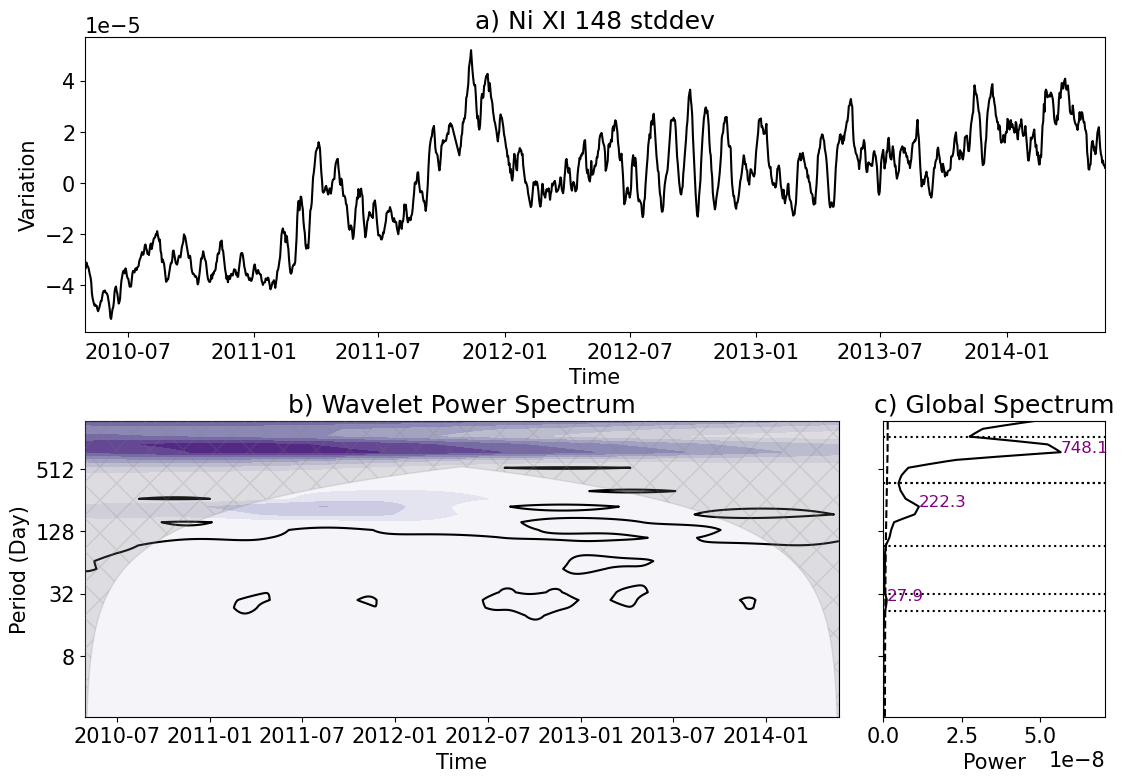

In [ ]:
daily_df=daily_df[daily_df.index<=pd.to_datetime('2014-05-24')]

do_wavelet(sst=daily_df['median_of_'+'amplitude'].values,
    dt=1,
    time=daily_df.index,
    show_peaks=True,
    unit=None,
    title=selected_band.loc[index]['Line Name']+' '+'amplitude',
    fig_name='output/daily_wavelet/'+property+'/'+selected_band.loc[index]['Line Name']+'_wavelet.png') 

## ignore solar eclipse


In [ ]:
index=0

with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
    fit_df = pickle.load(file)
fit_df.set_index('time',inplace=True)

stddev_of_mean=fit_df['mean'].resample('D').agg(np.nanstd)
stddev_of_stddev=fit_df['stddev'].resample('D').agg(np.nanstd)
stddev_of_amplitude=fit_df['amplitude'].resample('D').agg(np.nanstd)
available_data=fit_df['amplitude'].resample('D').agg(f)


columns_to_agg = ['amplitude', 'mean', 'stddev']
daily_median = fit_df[columns_to_agg].resample('D').agg(np.nanmedian)

# Create a new DataFrame 'daily_fit_df' to store the daily median, stddev, and amplitude
# fwhm=2.3*stddev
daily_df_eclipse = pd.DataFrame()
daily_df_eclipse['median_of_mean'] = daily_median['mean']
daily_df_eclipse['median_of_stddev'] = daily_median['stddev']
daily_df_eclipse['median_of_amplitude'] = daily_median['amplitude']

daily_df_eclipse['stddev_of_mean']=stddev_of_mean
daily_df_eclipse['stddev_of_stddev']=stddev_of_stddev
daily_df_eclipse['stddev_of_amplitude']=stddev_of_amplitude

daily_df_eclipse['available_data']=available_data

In [ ]:
daily_df_eclipse=daily_df_eclipse[daily_df_eclipse.index<=pd.to_datetime('2014-05-24')]

Data variance =  4.708389952239654e-10


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


([27.86608729549853, 222.2660872954987, 748.0660872954992],
 array([ 21.8660873,  93.4660873, 374.0660873]),
 array([  31.6660873,  374.0660873, 1057.8660873]))

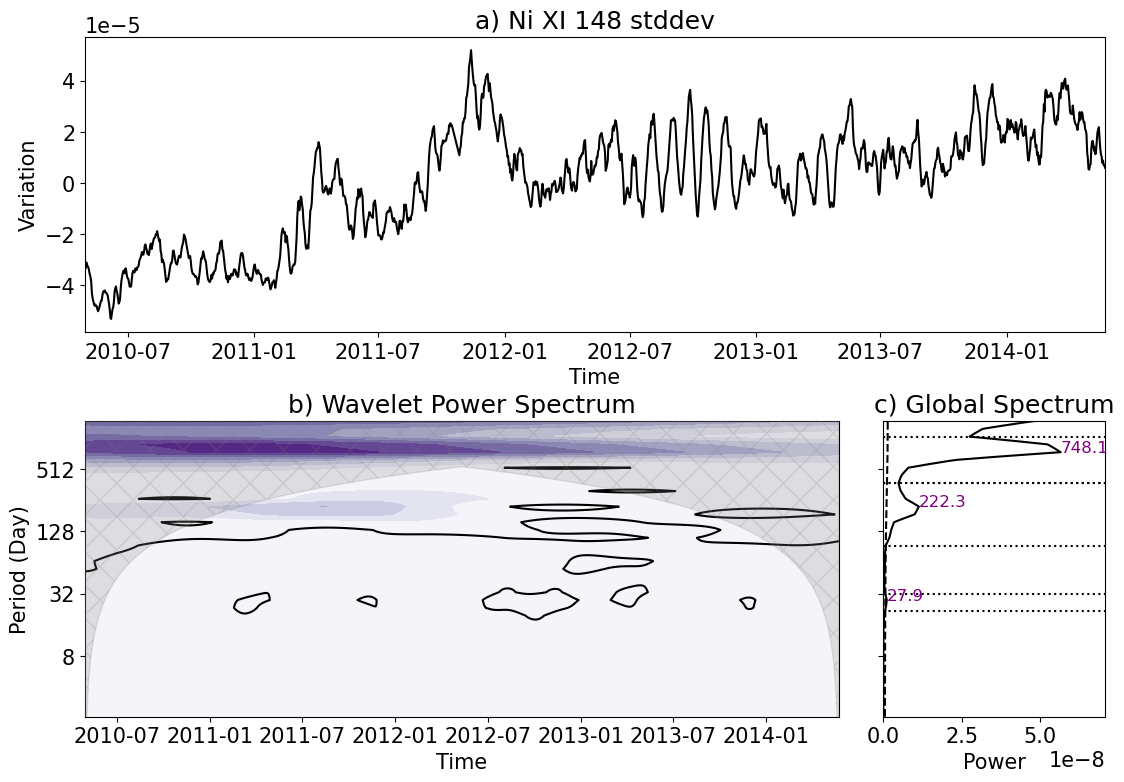

In [ ]:
do_wavelet(sst=daily_df_eclipse['median_of_'+'amplitude'].values,
    dt=1,
    time=daily_df_eclipse.index,
    show_peaks=True,
    unit=None,
    title=selected_band.loc[index]['Line Name']+' '+'amplitude',
    # fig_name='output/daily_wavelet/'+property+'/'+selected_band.loc[index]['Line Name']+'_wavelet.png'
    ) 

Data variance =  7.916285241265782e-16


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


([55.666087295498556, 93.46608729549858, 187.06608729549868],
 array([ 23.4660873,  66.0660873, 111.2660873]),
 array([ 66.0660873, 111.2660873, 259.0660873]))

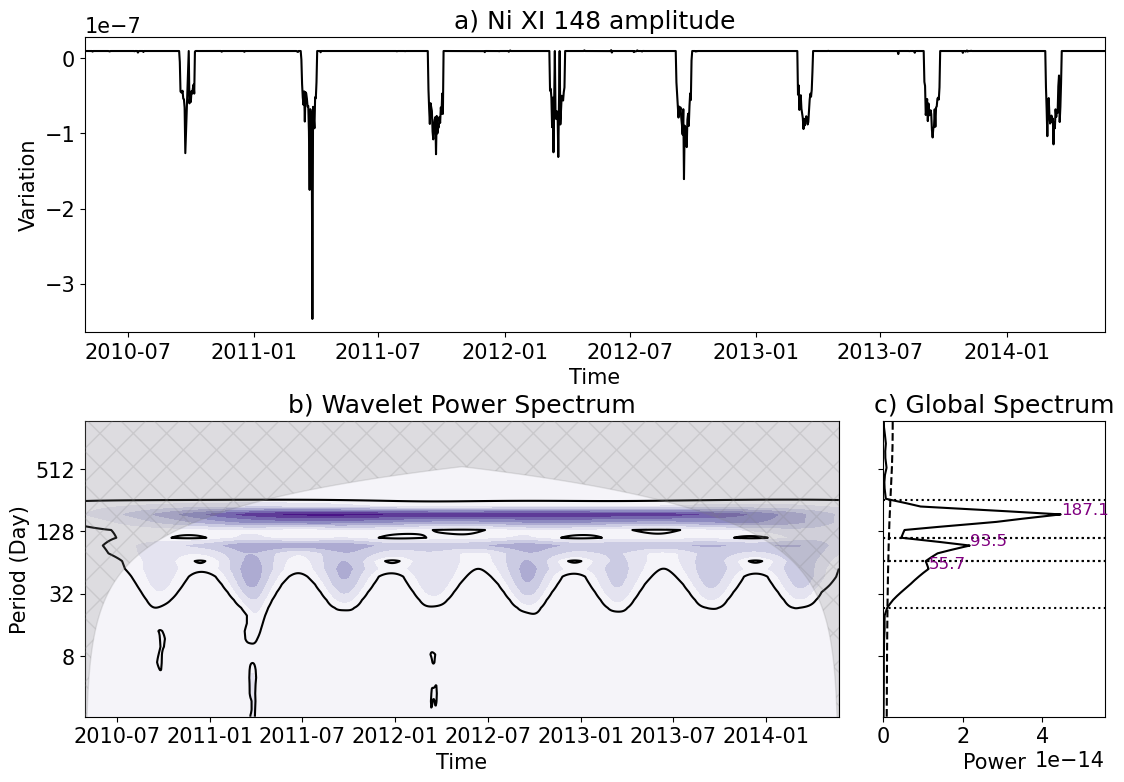

In [ ]:
do_wavelet(sst=daily_df_eclipse['median_of_'+'amplitude'].values-daily_df['median_of_'+'amplitude'].values,
    dt=1,
    time=daily_df_eclipse.index,
    show_peaks=True,
    unit=None,
    title=selected_band.loc[index]['Line Name']+' '+'amplitude',
    # fig_name='output/daily_wavelet/'+property+'/'+selected_band.loc[index]['Line Name']+'_wavelet.png'
    ) 

## Draw solar eclipse impact

In [ ]:
def f(x):
    y=np.size(x)-np.sum(np.isnan(x))
    return y
        
for index in selected_band.index[:]:
    with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        fit_df = pickle.load(file)
    fit_df.set_index('time',inplace=True)

    # fit_df['amplitude']=np.where(fit_df['eclipse_flag'].values==0,fit_df['amplitude'].values,np.nan)
    # fit_df['mean']=np.where(fit_df['eclipse_flag'].values==0,fit_df['mean'].values,np.nan)
    # fit_df['stddev']=np.where(fit_df['eclipse_flag'].values==0,fit_df['stddev'].values,np.nan)

    stddev_of_mean=fit_df['mean'].resample('D').agg(np.nanstd)
    stddev_of_stddev=fit_df['stddev'].resample('D').agg(np.nanstd)
    stddev_of_amplitude=fit_df['amplitude'].resample('D').agg(np.nanstd)
    available_data=fit_df['amplitude'].resample('D').agg(f)


    columns_to_agg = ['amplitude', 'mean', 'stddev']
    daily_median = fit_df[columns_to_agg].resample('D').agg(np.nanmedian)

    # Create a new DataFrame 'daily_fit_df' to store the daily median, stddev, and amplitude
    # fwhm=2.3*stddev
    daily_df = pd.DataFrame()
    daily_df['median_of_mean'] = daily_median['mean']
    daily_df['median_of_stddev'] = daily_median['stddev']
    daily_df['median_of_amplitude'] = daily_median['amplitude']

    daily_df['stddev_of_mean']=stddev_of_mean
    daily_df['stddev_of_stddev']=stddev_of_stddev
    daily_df['stddev_of_amplitude']=stddev_of_amplitude

    daily_df['available_data']=available_data

    # save daily_df
    with open('./data/daily_df/no_eclipse_process/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'wb') as file:
        pickle.dump(daily_df, file) 

# test

In [54]:
import importlib
importlib.reload(do_wavelet)

<module 'do_wavelet' from 'd:\\py_repo\\EVE-spectrum-correction\\Chapter4_v3\\basic_ops\\eve_ops\\do_wavelet.py'>

Data variance =  1.1428831143388192
wave shape:  (31, 380)
period shape:  (31,)
scale shape:  (31,)
coi shape:  (380,)


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


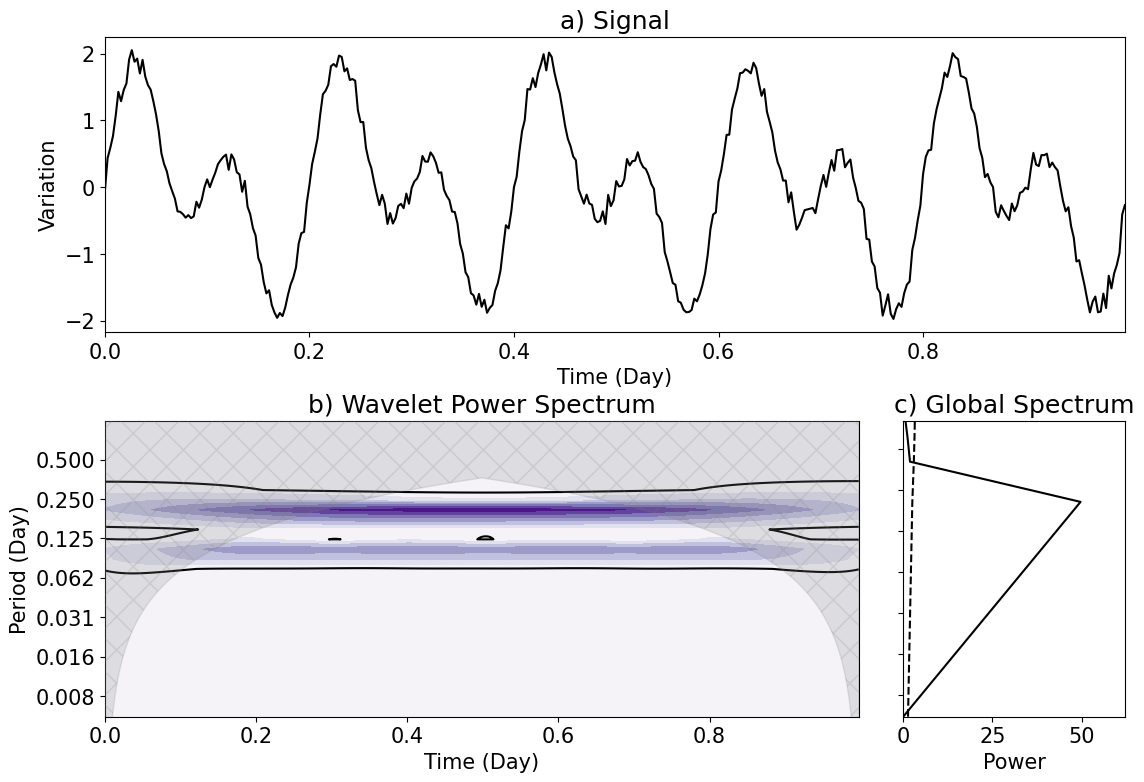

([], array([], dtype=float64), array([], dtype=float64))

In [50]:
import pandas as pd
import numpy as np
import do_wavelet
length= 380
sst=np.sin( np.arange(length)*2*np.pi/(length*0.2)) +np.random.randn(length)*0.1+\
1.1*np.sin( np.arange(length)*2*np.pi/(length*0.1))


do_wavelet.do_wavelet(
            sst, 1/length, 
        #    time=time, 
           unit='Day',  num=50)

Data variance =  4.709296744884503e-10
wave shape:  (39, 1486)
period shape:  (39,)
scale shape:  (39,)
coi shape:  (1486,)
peaks: [nan, 9.638171177272117e-09, 5.656981902344444e-08]
periods: [nan, 239.23269615331523, 834.9916623932752]


d:\py_repo\EVE-spectrum-correction\Chapter4_v3\basic_ops\eve_ops\do_wavelet.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


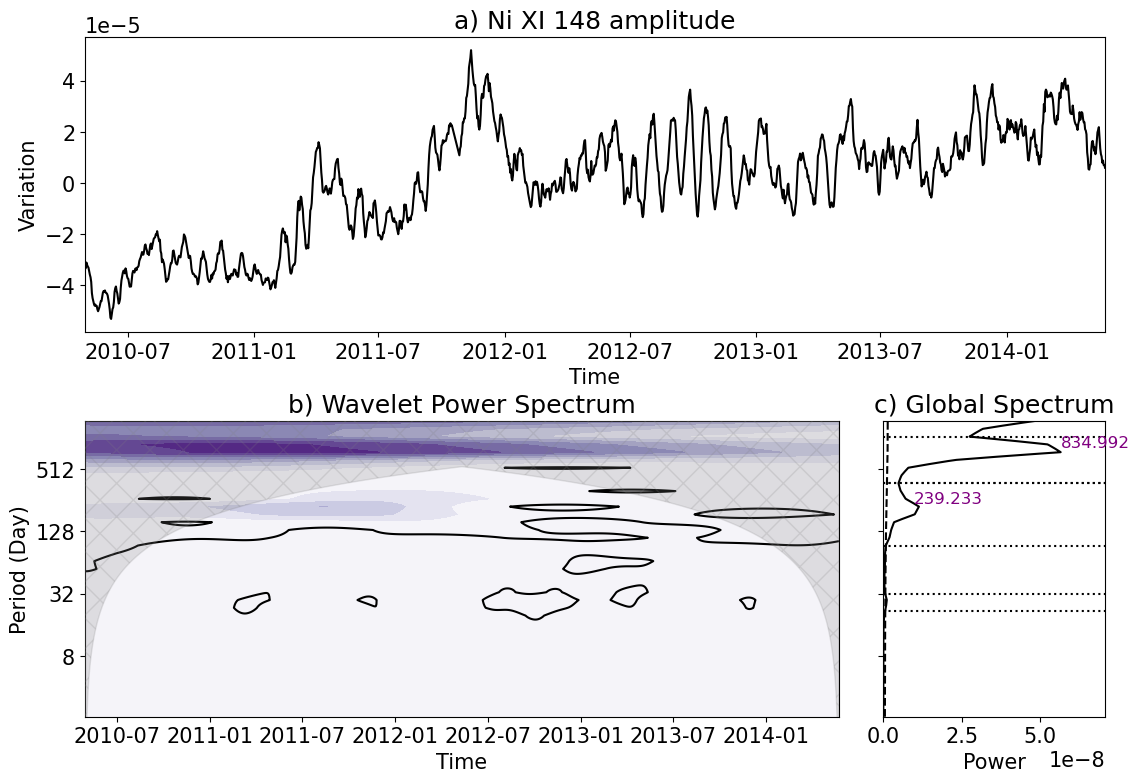

([nan, 239.23269615331523, 834.9916623932752],
 array([ 21.8660873,  93.4660873, 374.0660873]),
 array([  31.6660873,  374.0660873, 1057.8660873]))

In [55]:
band_index = 0
with open('./data/daily_df/daily_df_'+selected_band.loc[band_index]['Line Name']+'.pkl', 'rb') as file:
    daily_df = pickle.load(file)


daily_df=daily_df[daily_df.index<=pd.to_datetime('2014-05-24')]


do_wavelet.do_wavelet(
    daily_df['median_of_'+'amplitude'].values,
    dt=1,
    time=daily_df.index,
    show_peaks=True,
    unit=None,
    title=selected_band.loc[band_index]['Line Name']+' '+'amplitude',
)